In [555]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src/utils')
import ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from sklearn.manifold import TSNE
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

from data import preprocessing

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Variables


In [556]:
num_topics = 5
use_title = True
stemming = True
lemmatization = True
lib = "spacy"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Note
We also had ```gensim``` supported for preprocessing, but realized that even in their official docs, they make it a point that this should not be a use case! After having odd problems with their lemmatization routines (and ```pattern```), we just dropped it...

# Data loading and preparation

## load

In [557]:
with open(input_path, encoding="utf-8") as f:
    data = json.load(f)
data_df = pd.json_normalize(data['papers'])
corpus = data_df["abstract"]
if use_title:
    corpus = data_df["title"] + " " + corpus 


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## preprocess

In [558]:
corpus = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15
)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dropping 0 entries of corpus, due to nan ...


2it [00:00, 14.39it/s]

Starting tokenization ...


1261it [01:03, 19.88it/s]


In [559]:
dictionary = corpora.Dictionary(corpus["token"]) 
BoW_corpus = [dictionary.doc2bow(text) for text in corpus["token"]]

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [560]:
tfidf = models.TfidfModel(BoW_corpus)
corpus_tfidf = tfidf[BoW_corpus]

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# LSI

## TFIDF

In [561]:
lsi_tfidf = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics)# train model
lsi_tfidf[corpus_tfidf[1]]  # apply model to  document

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.2256233505206011),
 (1, 0.037889319049073396),
 (2, 0.04687524515749555),
 (3, -0.013618879872424886),
 (4, -8.26085965997805e-05)]

## Bag of Words

In [562]:
lsi_bow = models.LsiModel(BoW_corpus, id2word=dictionary, num_topics=num_topics)
lsi_bow[BoW_corpus[1]]  # apply model to  document

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 10.014646358918384),
 (1, 1.6641224912932333),
 (2, 1.2918103769573681),
 (3, -2.8778173096990454),
 (4, 5.120369141755593)]

# LDA

## init

In [563]:
# LDA model training 
lda_model = models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Inspect

In [564]:
preprocessing_str = f"(Preprocessing with {lib}, Stemming = {stemming}, Lemmatization = {lemmatization})"

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [565]:
abstract_count = 0
for abstract in data_df["abstract"]:
    if abstract:
        abstract_count += 1

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [566]:
print("There are " + str(len(data_df["abstract"])) + f" Papers. {str(abstract_count)} of them have Abstracts.")

There are 1261 Papers. 1225 of them have Abstracts.


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Keywords

In [567]:
for keyword in data_df["keywords"]:
    print(keyword)

['metric learning', 'convex optimization', 'semi-definite programming', 'first-order methods', 'eigenvalue optimization', 'matrix factorization']
['feature selection', 'mutual information']
['active learning', 'selective sampling', 'model selection', 'classification']
['statistical learning theory', 'active learning', 'ranking', 'pairwise ranking']
['distributed computing', 'online learning', 'stochastic optimization', 'regret bounds']
['clustering', 'active clustering', 'k-median', 'approximation algorithms', 'approximation sta-     bility', 'clustering accuracy']
['classification with a reject option', 'perfect classification', 'selective classification', 'ac-     tive learning', 'selective sampling', 'disagreement coefficient', 'teaching dimension']
['global optimization', 'model selection', 'neural networks', 'deep learning']
['optical character recognition', 'probability bounding', 'document-specific modeling']
['sparsity', 'kernel', 'non-parametric', 'convex']
['low rank', 'Riema

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [568]:
print(f"The Dataset contains {len(data_df)} Papers")
count_keywords = 0
all_keywords = []
for keyword in data_df["keywords"]:
    if keyword and keyword[0]:
        count_keywords += 1
        all_keywords = all_keywords + keyword
print(f"{count_keywords} of them contain Keywords.")
print(f"There are {len(all_keywords)} Keywords. {len(set(all_keywords))} of them are unique.")


The Dataset contains 1261 Papers
1108 of them contain Keywords.
There are 4378 Keywords. 3139 of them are unique.


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Corpus

In [569]:
pprint.pprint(dictionary.token2id)#token -> tokenId.

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'  ': 0,
 '   ': 1,
 '    ': 80,
 '     ': 4109,
 '      ': 629,
 '       ': 4929,
 '-pron-': 2,
 '000': 2808,
 '05': 3259,
 '10': 2116,
 '100': 1804,
 '1000': 2362,
 '100x': 5172,
 '12': 2621,
 '120': 2897,
 '121': 2637,
 '127': 2212,
 '1358': 2148,
 '140': 3277,
 '1442': 3752,
 '145': 2756,
 '1485': 2117,
 '15': 2213,
 '1510': 2118,
 '152': 2757,
 '16': 3783,
 '160': 3747,
 '1600': 466,
 '168': 4887,
 '17': 2551,
 '1744': 3144,
 '179': 2638,
 '18': 2149,
 '1933': 1248,
 '1950': 3597,
 '1964': 4466,
 '1966': 4242,
 '1972': 2472,
 '1973': 4467,
 '1975': 3312,
 '1978': 5134,
 '1979': 2959,
 '1982': 5417,
 '1984': 4626,
 '1987': 4198,
 '1988': 3,
 '1989': 4825,
 '1990': 4884,
 '1992': 2456,
 '1993': 2746,
 '1994': 4515,
 '1995': 3372,
 '1996': 4,
 '1999': 81,
 '1d': 4286,
 '20': 2196,
 '200': 3648,
 '2000': 878,
 '2001': 4592,
 '2002': 1249,
 '2003': 1647,
 '2004': 879,
 '2005': 5,
 '2006': 1743,
 '2007': 857,
 '2008': 82,
 '2009': 858,
 '2009a': 3694,
 '2009b': 3623,
 '2010': 859,
 '20

 'crimin': 4951,
 'crisp': 3463,
 'criteria': 4273,
 'criterion': 101,
 'critic': 1751,
 'crm': 2961,
 'cross': 1546,
 'crosscat': 3621,
 'crossmod': 4153,
 'crowd': 2781,
 'crowdsourc': 543,
 'crowdwork': 4349,
 'crucial': 1724,
 'cryptogen': 3538,
 'cryptographi': 1770,
 'cs': 2370,
 'cs1': 935,
 'csc': 4101,
 'csi': 2903,
 'csiszã': 3859,
 'csp': 2920,
 'ct': 1302,
 'ctc': 3472,
 'ctree': 3171,
 'cube': 4517,
 'cubic': 960,
 'cuda': 2838,
 'cue': 1808,
 'culmin': 3822,
 'cultur': 3203,
 'cumul': 2015,
 'cup': 1703,
 'cur': 2004,
 'curb': 4566,
 'currennt': 2839,
 'current': 1170,
 'curricula': 4182,
 'curriculum': 3204,
 'curs': 1582,
 'curv': 1489,
 'curvatur': 1090,
 'custom': 603,
 'customari': 4186,
 'cut': 1365,
 'cutler': 4557,
 'cutsiz': 1748,
 'cv': 5475,
 'cvar': 4274,
 'cvb': 3925,
 'cvb0': 4057,
 'cvm': 2202,
 'cwae': 5394,
 'cycl': 1656,
 'cyclic': 1657,
 'cython': 4267,
 'cytometri': 3010,
 'da': 4513,
 'dace': 2651,
 'dadm': 4187,
 'dae': 4652,
 'dag': 1385,
 'dagitti'

 'hartigan': 3710,
 'hartikainen': 2557,
 'hash': 2316,
 'hasmm': 4441,
 'hast': 3253,
 'hausdorff': 990,
 'hausman': 3494,
 'haussler': 3671,
 'havakv': 4914,
 'havebeen': 5114,
 'hawk': 4346,
 'haxbi': 4244,
 'haystack': 4741,
 'hazan': 3600,
 'hazard': 3734,
 'hcrf': 3544,
 'head': 1571,
 'health': 3417,
 'healthcar': 3418,
 'heart': 2763,
 'heavi': 3232,
 'heavili': 845,
 'hedg': 2414,
 'held': 5347,
 'heldout': 3716,
 'helling': 2791,
 'help': 797,
 'hem': 2336,
 'henc': 1387,
 'henckel': 5449,
 'herbrich': 5137,
 'herbster': 4288,
 'herd': 3212,
 'herebi': 4898,
 'hermitian': 2966,
 'hessian': 1094,
 'heterogen': 611,
 'heteroscedast': 3193,
 'heurist': 118,
 'hidden': 2067,
 'hide': 1890,
 'hierarch': 359,
 'hierarchi': 3217,
 'high': 256,
 'highlight': 1368,
 'hilbert': 445,
 'hill': 1786,
 'hinder': 2829,
 'hindsight': 4733,
 'hing': 1471,
 'hint': 2189,
 'hire': 3858,
 'histogram': 1988,
 'histolog': 3545,
 'histor': 404,
 'histori': 1277,
 'hit': 2485,
 'hitherto': 4581,
 'h

 'kryov': 5414,
 'ksvd': 5399,
 'kuhn': 4068,
 'kuleuven': 2245,
 'kullbach': 4569,
 'kullback': 1132,
 'kuramoto': 3948,
 'kurdyka': 4450,
 'kuzmin': 971,
 'kwik': 1737,
 'kymat': 5162,
 'kymatio': 5163,
 'kã': 4297,
 'l0': 1197,
 'l1': 447,
 'l2': 448,
 'l4': 5400,
 'l_0': 4463,
 'l_1': 4305,
 'la': 5014,
 'laan': 4162,
 'label': 43,
 'labor': 1532,
 'laboratori': 3788,
 'lack': 1848,
 'lad': 2851,
 'lafon': 3654,
 'lag': 5043,
 'lagrang': 3060,
 'lagrangian': 1030,
 'lalda': 1329,
 'lamm': 3833,
 'lanc': 4546,
 'landmark': 295,
 'landscap': 2795,
 'lanford': 4207,
 'langevin': 3199,
 'languag': 615,
 'laplac': 1222,
 'laplacian': 1072,
 'laptop': 4240,
 'larg': 44,
 'largescal': 4809,
 'lasso': 701,
 'lasvm': 2203,
 'late': 665,
 'latenc': 260,
 'latent': 782,
 'later': 1011,
 'lattic': 3527,
 'law': 2796,
 'layer': 2498,
 'lazi': 1116,
 'lazifi': 4801,
 'lazify': 4802,
 'lazili': 5190,
 'lcsl': 2074,
 'lcss': 2663,
 'lda': 1330,
 'lder': 4521,
 'ldp': 5466,
 'le': 3931,
 'lead': 12

 'multistag': 1149,
 'multistep': 5489,
 'multitask': 692,
 'multithread': 2918,
 'multitud': 5269,
 'multivari': 1389,
 'multiway': 3774,
 'munich': 2843,
 'murray': 3091,
 'music': 2337,
 'mutat': 5197,
 'mutual': 136,
 'mvc': 1999,
 'mvolkov': 2373,
 'mxnet': 5071,
 'myoelectr': 3638,
 'mysteri': 5445,
 'mã': 4087,
 'mσ': 938,
 'nade': 3838,
 'nadler': 4031,
 'naeglelab': 4507,
 'naiv': 493,
 'nan': 3933,
 'narrow': 2438,
 'nash': 1457,
 'nation': 1534,
 'nativ': 3749,
 'natur': 137,
 'navier': 4501,
 'navig': 1076,
 'naã': 2859,
 'naïv': 1668,
 'ncaa': 2630,
 'nd2': 1669,
 'ndcg': 2374,
 'near': 411,
 'nearbi': 4025,
 'nearest': 1945,
 'nebula': 5016,
 'necess': 1286,
 'necessari': 1359,
 'necessarili': 786,
 'necessit': 4430,
 'nee': 4014,
 'need': 57,
 'negat': 975,
 'neglect': 2018,
 'neglig': 2108,
 'neighbor': 1504,
 'neighborhood': 1705,
 'neighbourhood': 4218,
 'nelson': 4629,
 'nemirovski': 1397,
 'nes': 2349,
 'nesarc': 2399,
 'nest': 2439,
 'nesterov': 1717,
 'net': 619,


 'precis': 417,
 'preclud': 3368,
 'precognit': 4428,
 'precondit': 4394,
 'precursor': 3369,
 'predecessor': 2191,
 'predefin': 4179,
 'predetermin': 2719,
 'predic': 2145,
 'predict': 266,
 'predictor': 643,
 'predomin': 1287,
 'preexist': 3371,
 'prefac': 2956,
 'prefer': 221,
 'preferenti': 4510,
 'preferredai': 5240,
 'prefix': 3258,
 'preform': 3917,
 'preliminari': 3691,
 'premis': 1856,
 'premultiply': 5295,
 'preorder': 4234,
 'prepar': 4568,
 'preprocess': 693,
 'prescrib': 2469,
 'prescript': 4824,
 'preselect': 4692,
 'presenc': 908,
 'present': 143,
 'preserv': 326,
 'presidenti': 1314,
 'prespecifi': 4996,
 'presum': 4693,
 'pret': 3495,
 'pretti': 4617,
 'prevail': 4116,
 'preval': 3227,
 'prevent': 2507,
 'previous': 371,
 'price': 1315,
 'primal': 644,
 'primari': 144,
 'primarili': 525,
 'primit': 1371,
 'princip': 1078,
 'principl': 1079,
 'print': 3177,
 'prior': 909,
 'priori': 1418,
 'priorit': 3846,
 'prioriti': 2030,
 'privaci': 2020,
 'privat': 2021,
 'privileg

 'stationar': 2046,
 'stationari': 1566,
 'statist': 161,
 'statistician': 2296,
 'statur': 2170,
 'stay': 3437,
 'steadi': 3810,
 'steer': 4380,
 'stefanuyk': 2958,
 'stein': 2281,
 'steinwart': 3673,
 'stem': 914,
 'step': 232,
 'stepsiz': 3867,
 'stereo': 3362,
 'stevenhoi': 3288,
 'stick': 1883,
 'sticki': 5468,
 'stigum': 4296,
 'stipul': 2993,
 'stl': 4529,
 'stm': 2525,
 'stoc': 5065,
 'stochast': 274,
 'stock': 3290,
 'stodden': 1653,
 'stoke': 4503,
 'stoltz': 2419,
 'stone': 2420,
 'stop': 2282,
 'storag': 2078,
 'store': 1612,
 'stori': 5288,
 'storm': 2807,
 'stormer': 5230,
 'straggl': 4807,
 'straggler': 3514,
 'straightforward': 1099,
 'strand': 931,
 'strassen': 3576,
 'strata': 1539,
 'strateg': 2911,
 'strategi': 162,
 'strategyâ': 2831,
 'stratif': 3423,
 'stratifi': 1540,
 'stratum': 3026,
 'stre': 3607,
 'stream': 333,
 'streamlin': 5385,
 'street': 2691,
 'strength': 713,
 'strengthen': 3225,
 'stress': 1480,
 'stretch': 5402,
 'strict': 1036,
 'striebel': 4606,
 

 'valu': 432,
 'valuabl': 3844,
 'van': 1944,
 'vanilla': 3099,
 'vanish': 2110,
 'vapnik': 2001,
 'var': 2312,
 'vari': 1200,
 'variabl': 433,
 'varianc': 856,
 'variant': 676,
 'variat': 465,
 'varieti': 627,
 'vast': 1284,
 'vazirani': 4127,
 'vb': 3160,
 'vc': 987,
 've': 2860,
 'vector': 512,
 'vectori': 4342,
 'vehicl': 4075,
 'vener': 4167,
 'veri': 434,
 'verif': 77,
 'verifi': 1130,
 'verlet': 5231,
 'versa': 1506,
 'versatil': 1700,
 'version': 677,
 'versus': 310,
 'vertex': 760,
 'vf': 4913,
 'vgg': 5313,
 'vhem': 2338,
 'vi': 3490,
 'viabl': 2333,
 'vibrant': 3283,
 'vice': 1507,
 'video': 1446,
 'view': 1084,
 'viewer': 5409,
 'viewpoint': 2387,
 'vignett': 3182,
 'vii': 3491,
 'violat': 1403,
 'violenc': 3497,
 'viral': 3935,
 'virtu': 3999,
 'virtual': 2100,
 'vis': 3324,
 'vishwanathan': 5180,
 'visibl': 2861,
 'vision': 578,
 'visit': 1741,
 'visual': 877,
 'visualis': 4337,
 'visuomotor': 3305,
 'vital': 4486,
 'viterbi': 2195,
 'vito': 3674,
 'viz': 2443,
 'vladimir

In [570]:
pprint.pprint(dictionary.dfs) # token_id -> how many documents contain this token.

{0: 731,
 1: 114,
 2: 1193,
 3: 1,
 4: 4,
 5: 9,
 6: 164,
 7: 83,
 8: 676,
 9: 410,
 10: 174,
 11: 2,
 12: 73,
 13: 113,
 14: 19,
 15: 62,
 16: 415,
 17: 73,
 18: 232,
 19: 281,
 20: 574,
 21: 123,
 22: 247,
 23: 41,
 24: 72,
 25: 2,
 26: 319,
 27: 1,
 28: 21,
 29: 11,
 30: 15,
 31: 67,
 32: 159,
 33: 83,
 34: 229,
 35: 19,
 36: 97,
 37: 248,
 38: 11,
 39: 45,
 40: 238,
 41: 126,
 42: 165,
 43: 106,
 44: 347,
 45: 656,
 46: 1,
 47: 1,
 48: 1,
 49: 4,
 50: 94,
 51: 216,
 52: 73,
 53: 610,
 54: 50,
 55: 160,
 56: 90,
 57: 93,
 58: 305,
 59: 184,
 60: 215,
 61: 74,
 62: 434,
 63: 194,
 64: 1,
 65: 482,
 66: 434,
 67: 600,
 68: 439,
 69: 31,
 70: 527,
 71: 24,
 72: 575,
 73: 95,
 74: 233,
 75: 29,
 76: 2,
 77: 4,
 78: 1,
 79: 2,
 80: 30,
 81: 5,
 82: 10,
 83: 145,
 84: 25,
 85: 20,
 86: 268,
 87: 158,
 88: 23,
 89: 503,
 90: 5,
 91: 8,
 92: 266,
 93: 86,
 94: 239,
 95: 17,
 96: 109,
 97: 45,
 98: 11,
 99: 241,
 100: 59,
 101: 50,
 102: 12,
 103: 114,
 104: 37,
 105: 214,
 106: 222,
 107: 1

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


107,
 430: 41,
 431: 16,
 432: 134,
 433: 188,
 434: 86,
 435: 20,
 436: 11,
 437: 5,
 438: 11,
 439: 19,
 440: 87,
 441: 34,
 442: 93,
 443: 2,
 444: 85,
 445: 35,
 446: 145,
 447: 16,
 448: 5,
 449: 19,
 450: 87,
 451: 1,
 452: 49,
 453: 190,
 454: 38,
 455: 16,
 456: 5,
 457: 172,
 458: 69,
 459: 8,
 460: 12,
 461: 89,
 462: 39,
 463: 12,
 464: 63,
 465: 84,
 466: 1,
 467: 36,
 468: 3,
 469: 27,
 470: 86,
 471: 76,
 472: 185,
 473: 95,
 474: 12,
 475: 99,
 476: 82,
 477: 6,
 478: 25,
 479: 13,
 480: 115,
 481: 74,
 482: 127,
 483: 14,
 484: 69,
 485: 3,
 486: 244,
 487: 1,
 488: 34,
 489: 128,
 490: 35,
 491: 27,
 492: 130,
 493: 16,
 494: 75,
 495: 29,
 496: 7,
 497: 65,
 498: 17,
 499: 9,
 500: 59,
 501: 15,
 502: 78,
 503: 108,
 504: 167,
 505: 1,
 506: 115,
 507: 54,
 508: 21,
 509: 81,
 510: 174,
 511: 7,
 512: 138,
 513: 53,
 514: 23,
 515: 10,
 516: 35,
 517: 71,
 518: 4,
 519: 36,
 520: 61,
 521: 120,
 522: 54,
 523: 87,
 524: 80,
 525: 6,
 526: 238,
 527: 96,
 528: 36,
 529

 1411: 26,
 1412: 9,
 1413: 24,
 1414: 19,
 1415: 8,
 1416: 11,
 1417: 1,
 1418: 14,
 1419: 14,
 1420: 1,
 1421: 14,
 1422: 2,
 1423: 33,
 1424: 14,
 1425: 10,
 1426: 2,
 1427: 6,
 1428: 2,
 1429: 1,
 1430: 10,
 1431: 9,
 1432: 1,
 1433: 42,
 1434: 12,
 1435: 4,
 1436: 1,
 1437: 5,
 1438: 1,
 1439: 13,
 1440: 3,
 1441: 43,
 1442: 1,
 1443: 1,
 1444: 4,
 1445: 18,
 1446: 15,
 1447: 3,
 1448: 5,
 1449: 1,
 1450: 5,
 1451: 3,
 1452: 3,
 1453: 2,
 1454: 1,
 1455: 4,
 1456: 19,
 1457: 2,
 1458: 2,
 1459: 4,
 1460: 5,
 1461: 3,
 1462: 2,
 1463: 6,
 1464: 8,
 1465: 22,
 1466: 1,
 1467: 12,
 1468: 11,
 1469: 37,
 1470: 2,
 1471: 12,
 1472: 43,
 1473: 17,
 1474: 6,
 1475: 13,
 1476: 17,
 1477: 34,
 1478: 1,
 1479: 16,
 1480: 1,
 1481: 15,
 1482: 35,
 1483: 24,
 1484: 5,
 1485: 6,
 1486: 26,
 1487: 4,
 1488: 4,
 1489: 12,
 1490: 29,
 1491: 5,
 1492: 7,
 1493: 10,
 1494: 3,
 1495: 23,
 1496: 4,
 1497: 2,
 1498: 5,
 1499: 5,
 1500: 21,
 1501: 5,
 1502: 3,
 1503: 13,
 1504: 25,
 1505: 17,
 1506: 4,

 2447: 3,
 2448: 9,
 2449: 11,
 2450: 1,
 2451: 1,
 2452: 1,
 2453: 1,
 2454: 1,
 2455: 2,
 2456: 1,
 2457: 2,
 2458: 1,
 2459: 1,
 2460: 2,
 2461: 1,
 2462: 1,
 2463: 1,
 2464: 1,
 2465: 1,
 2466: 2,
 2467: 8,
 2468: 6,
 2469: 3,
 2470: 5,
 2471: 2,
 2472: 3,
 2473: 2,
 2474: 1,
 2475: 5,
 2476: 1,
 2477: 3,
 2478: 1,
 2479: 7,
 2480: 3,
 2481: 1,
 2482: 11,
 2483: 3,
 2484: 2,
 2485: 2,
 2486: 2,
 2487: 3,
 2488: 7,
 2489: 1,
 2490: 2,
 2491: 3,
 2492: 1,
 2493: 6,
 2494: 3,
 2495: 1,
 2496: 1,
 2497: 1,
 2498: 29,
 2499: 12,
 2500: 10,
 2501: 8,
 2502: 16,
 2503: 7,
 2504: 3,
 2505: 8,
 2506: 4,
 2507: 7,
 2508: 2,
 2509: 1,
 2510: 1,
 2511: 7,
 2512: 5,
 2513: 3,
 2514: 1,
 2515: 2,
 2516: 2,
 2517: 1,
 2518: 3,
 2519: 1,
 2520: 15,
 2521: 3,
 2522: 3,
 2523: 1,
 2524: 6,
 2525: 2,
 2526: 8,
 2527: 2,
 2528: 9,
 2529: 6,
 2530: 2,
 2531: 4,
 2532: 9,
 2533: 8,
 2534: 1,
 2535: 1,
 2536: 6,
 2537: 3,
 2538: 2,
 2539: 3,
 2540: 6,
 2541: 5,
 2542: 2,
 2543: 1,
 2544: 1,
 2545: 1,
 25

 3427: 3,
 3428: 1,
 3429: 1,
 3430: 1,
 3431: 1,
 3432: 1,
 3433: 2,
 3434: 1,
 3435: 1,
 3436: 1,
 3437: 2,
 3438: 1,
 3439: 1,
 3440: 4,
 3441: 1,
 3442: 1,
 3443: 3,
 3444: 8,
 3445: 1,
 3446: 1,
 3447: 4,
 3448: 1,
 3449: 1,
 3450: 1,
 3451: 1,
 3452: 1,
 3453: 1,
 3454: 5,
 3455: 1,
 3456: 2,
 3457: 1,
 3458: 1,
 3459: 1,
 3460: 5,
 3461: 1,
 3462: 5,
 3463: 1,
 3464: 1,
 3465: 2,
 3466: 1,
 3467: 2,
 3468: 3,
 3469: 6,
 3470: 1,
 3471: 1,
 3472: 1,
 3473: 1,
 3474: 4,
 3475: 1,
 3476: 1,
 3477: 1,
 3478: 4,
 3479: 1,
 3480: 1,
 3481: 1,
 3482: 1,
 3483: 2,
 3484: 3,
 3485: 6,
 3486: 1,
 3487: 2,
 3488: 1,
 3489: 2,
 3490: 2,
 3491: 1,
 3492: 1,
 3493: 2,
 3494: 1,
 3495: 1,
 3496: 1,
 3497: 1,
 3498: 2,
 3499: 2,
 3500: 1,
 3501: 1,
 3502: 1,
 3503: 3,
 3504: 2,
 3505: 1,
 3506: 2,
 3507: 1,
 3508: 2,
 3509: 1,
 3510: 1,
 3511: 1,
 3512: 1,
 3513: 1,
 3514: 2,
 3515: 1,
 3516: 2,
 3517: 1,
 3518: 1,
 3519: 1,
 3520: 1,
 3521: 2,
 3522: 2,
 3523: 3,
 3524: 1,
 3525: 2,
 3526: 1,


 4376: 1,
 4377: 1,
 4378: 1,
 4379: 1,
 4380: 1,
 4381: 1,
 4382: 1,
 4383: 1,
 4384: 1,
 4385: 1,
 4386: 1,
 4387: 3,
 4388: 2,
 4389: 1,
 4390: 1,
 4391: 1,
 4392: 1,
 4393: 1,
 4394: 3,
 4395: 1,
 4396: 2,
 4397: 1,
 4398: 1,
 4399: 1,
 4400: 1,
 4401: 1,
 4402: 1,
 4403: 1,
 4404: 1,
 4405: 1,
 4406: 1,
 4407: 1,
 4408: 1,
 4409: 2,
 4410: 1,
 4411: 1,
 4412: 1,
 4413: 1,
 4414: 1,
 4415: 1,
 4416: 1,
 4417: 1,
 4418: 2,
 4419: 1,
 4420: 1,
 4421: 1,
 4422: 4,
 4423: 1,
 4424: 1,
 4425: 1,
 4426: 1,
 4427: 1,
 4428: 1,
 4429: 1,
 4430: 2,
 4431: 1,
 4432: 1,
 4433: 2,
 4434: 1,
 4435: 1,
 4436: 2,
 4437: 1,
 4438: 2,
 4439: 1,
 4440: 1,
 4441: 1,
 4442: 1,
 4443: 1,
 4444: 1,
 4445: 1,
 4446: 1,
 4447: 2,
 4448: 1,
 4449: 1,
 4450: 2,
 4451: 2,
 4452: 1,
 4453: 1,
 4454: 1,
 4455: 1,
 4456: 2,
 4457: 1,
 4458: 1,
 4459: 1,
 4460: 1,
 4461: 1,
 4462: 1,
 4463: 1,
 4464: 1,
 4465: 1,
 4466: 1,
 4467: 1,
 4468: 1,
 4469: 3,
 4470: 1,
 4471: 3,
 4472: 1,
 4473: 1,
 4474: 2,
 4475: 1,


 5236: 1,
 5237: 1,
 5238: 1,
 5239: 1,
 5240: 1,
 5241: 1,
 5242: 1,
 5243: 1,
 5244: 1,
 5245: 1,
 5246: 1,
 5247: 1,
 5248: 2,
 5249: 1,
 5250: 1,
 5251: 1,
 5252: 3,
 5253: 1,
 5254: 1,
 5255: 1,
 5256: 1,
 5257: 1,
 5258: 1,
 5259: 1,
 5260: 1,
 5261: 1,
 5262: 2,
 5263: 1,
 5264: 1,
 5265: 1,
 5266: 1,
 5267: 2,
 5268: 1,
 5269: 1,
 5270: 1,
 5271: 1,
 5272: 1,
 5273: 1,
 5274: 1,
 5275: 1,
 5276: 1,
 5277: 1,
 5278: 1,
 5279: 1,
 5280: 2,
 5281: 1,
 5282: 1,
 5283: 1,
 5284: 1,
 5285: 1,
 5286: 1,
 5287: 1,
 5288: 1,
 5289: 1,
 5290: 1,
 5291: 1,
 5292: 1,
 5293: 1,
 5294: 1,
 5295: 1,
 5296: 1,
 5297: 1,
 5298: 1,
 5299: 1,
 5300: 1,
 5301: 1,
 5302: 1,
 5303: 1,
 5304: 1,
 5305: 1,
 5306: 1,
 5307: 1,
 5308: 1,
 5309: 1,
 5310: 1,
 5311: 1,
 5312: 1,
 5313: 1,
 5314: 1,
 5315: 1,
 5316: 1,
 5317: 1,
 5318: 1,
 5319: 1,
 5320: 1,
 5321: 1,
 5322: 1,
 5323: 1,
 5324: 1,
 5325: 1,
 5326: 1,
 5327: 1,
 5328: 1,
 5329: 1,
 5330: 1,
 5331: 1,
 5332: 1,
 5333: 1,
 5334: 1,
 5335: 1,


In [571]:
pprint.pprint(BoW_corpus)# list of (token_id, token_count) 

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 5),
  (1, 2),
  (2, 5),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 2),
  (9, 2),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 2),
  (23, 1),
  (24, 1),
  (25, 2),
  (26, 1),
  (27, 2),
  (28, 5),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 2),
  (36, 1),
  (37, 2),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 6),
  (46, 1),
  (47, 1),
  (48, 2),
  (49, 1),
  (50, 1),
  (51, 2),
  (52, 1),
  (53, 1),
  (54, 6),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 3),
  (59, 3),
  (60, 2),
  (61, 1),
  (62, 4),
  (63, 1),
  (64, 2),
  (65, 1),
  (66, 1),
  (67, 2),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 2),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1)],
 [(0, 8),
  (2, 7),
  (7, 1),
  (8, 1),
  (9, 1),
  (20, 1),
  (21, 1),
  (33, 1),
  (37, 3),
  (41, 1),
  (43, 1),
  (44, 1),
  

  (806, 3),
  (807, 1)],
 [(2, 4),
  (6, 2),
  (9, 1),
  (40, 1),
  (45, 2),
  (53, 5),
  (57, 1),
  (58, 3),
  (59, 1),
  (63, 1),
  (65, 1),
  (66, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (89, 3),
  (92, 1),
  (96, 3),
  (112, 4),
  (164, 1),
  (165, 1),
  (171, 1),
  (186, 1),
  (188, 1),
  (194, 1),
  (210, 1),
  (228, 1),
  (238, 5),
  (243, 4),
  (250, 1),
  (256, 1),
  (289, 1),
  (312, 1),
  (336, 1),
  (338, 1),
  (349, 1),
  (394, 1),
  (405, 1),
  (424, 5),
  (482, 1),
  (486, 1),
  (549, 1),
  (571, 2),
  (573, 1),
  (581, 2),
  (597, 2),
  (606, 2),
  (658, 3),
  (669, 1),
  (690, 1),
  (693, 1),
  (712, 2),
  (754, 1),
  (756, 1),
  (772, 2),
  (792, 1),
  (794, 1),
  (796, 1),
  (806, 1),
  (808, 1),
  (809, 1),
  (810, 2),
  (811, 1),
  (812, 1),
  (813, 5),
  (814, 1),
  (815, 1),
  (816, 2),
  (817, 4),
  (818, 9),
  (819, 1),
  (820, 9),
  (821, 5),
  (822, 1),
  (823, 1),
  (824, 1),
  (825, 1),
  (826, 1),
  (827, 1)],
 [(0, 4),
  (2, 4),
  (8, 1),
  (18, 1),
  (26,

  (229, 3),
  (232, 1),
  (238, 2),
  (256, 1),
  (265, 1),
  (272, 1),
  (274, 2),
  (300, 1),
  (306, 1),
  (315, 1),
  (333, 1),
  (354, 1),
  (381, 1),
  (406, 1),
  (411, 2),
  (418, 1),
  (440, 1),
  (447, 1),
  (449, 2),
  (453, 5),
  (458, 1),
  (470, 2),
  (472, 1),
  (488, 6),
  (512, 1),
  (524, 1),
  (635, 2),
  (663, 1),
  (695, 1),
  (733, 1),
  (742, 1),
  (747, 1),
  (754, 1),
  (776, 2),
  (787, 1),
  (939, 1),
  (1088, 1),
  (1121, 1),
  (1122, 1),
  (1123, 1),
  (1124, 1),
  (1125, 1),
  (1126, 1),
  (1127, 1),
  (1128, 1),
  (1129, 1),
  (1130, 1)],
 [(0, 9),
  (2, 9),
  (6, 1),
  (9, 1),
  (20, 1),
  (23, 1),
  (34, 3),
  (45, 1),
  (62, 1),
  (65, 1),
  (68, 1),
  (72, 1),
  (86, 5),
  (94, 3),
  (101, 2),
  (105, 2),
  (110, 1),
  (114, 1),
  (115, 3),
  (128, 5),
  (154, 2),
  (171, 1),
  (175, 1),
  (186, 2),
  (187, 1),
  (190, 2),
  (209, 1),
  (212, 1),
  (215, 1),
  (231, 1),
  (238, 1),
  (246, 2),
  (256, 1),
  (257, 1),
  (266, 1),
  (280, 1),
  (283, 1)

  (1259, 1),
  (1280, 1),
  (1285, 2),
  (1393, 1),
  (1412, 5),
  (1413, 1),
  (1414, 2),
  (1415, 3),
  (1416, 1),
  (1417, 1),
  (1418, 1),
  (1419, 1),
  (1420, 1),
  (1421, 1),
  (1422, 2),
  (1423, 3)],
 [(0, 1),
  (2, 6),
  (9, 1),
  (17, 2),
  (37, 1),
  (41, 1),
  (45, 3),
  (70, 2),
  (96, 2),
  (99, 1),
  (106, 1),
  (130, 1),
  (143, 2),
  (145, 2),
  (149, 2),
  (155, 2),
  (177, 2),
  (233, 1),
  (235, 2),
  (238, 3),
  (250, 1),
  (263, 3),
  (291, 1),
  (297, 2),
  (302, 2),
  (307, 3),
  (315, 1),
  (362, 1),
  (381, 2),
  (465, 2),
  (482, 1),
  (502, 1),
  (503, 1),
  (527, 2),
  (577, 1),
  (583, 1),
  (615, 2),
  (690, 5),
  (808, 1),
  (809, 1),
  (812, 1),
  (847, 1),
  (1014, 1),
  (1026, 3),
  (1042, 1),
  (1054, 1),
  (1075, 1),
  (1283, 16),
  (1357, 1),
  (1424, 1),
  (1425, 1),
  (1426, 2),
  (1427, 2),
  (1428, 1),
  (1429, 1),
  (1430, 1),
  (1431, 2),
  (1432, 1),
  (1433, 1),
  (1434, 1),
  (1435, 1),
  (1436, 1),
  (1437, 1),
  (1438, 1),
  (1439, 1),


  (524, 1),
  (599, 1),
  (601, 1),
  (674, 6),
  (699, 1),
  (704, 2),
  (716, 1),
  (723, 1),
  (747, 1),
  (781, 1),
  (824, 1),
  (833, 2),
  (846, 1),
  (909, 12),
  (921, 1),
  (1060, 1),
  (1086, 7),
  (1153, 1),
  (1560, 7),
  (1674, 1)],
 [(0, 1),
  (2, 1),
  (8, 1),
  (16, 3),
  (20, 1),
  (22, 2),
  (37, 4),
  (45, 5),
  (61, 1),
  (120, 1),
  (131, 1),
  (143, 1),
  (151, 2),
  (231, 1),
  (297, 1),
  (322, 1),
  (390, 1),
  (440, 1),
  (530, 1),
  (532, 1),
  (562, 1),
  (571, 5),
  (578, 3),
  (583, 1),
  (587, 1),
  (602, 1),
  (613, 1),
  (679, 1),
  (734, 1),
  (746, 2),
  (755, 1),
  (798, 1),
  (877, 1),
  (921, 1),
  (1472, 1),
  (1675, 1),
  (1676, 1),
  (1677, 1)],
 [(2, 6),
  (8, 7),
  (10, 1),
  (18, 1),
  (23, 2),
  (26, 2),
  (44, 2),
  (45, 4),
  (50, 1),
  (53, 2),
  (55, 1),
  (59, 1),
  (62, 8),
  (67, 6),
  (68, 2),
  (70, 1),
  (74, 1),
  (83, 1),
  (87, 2),
  (89, 1),
  (92, 2),
  (99, 1),
  (108, 1),
  (115, 3),
  (139, 4),
  (163, 1),
  (165, 1),
  (1

 [(0, 3),
  (2, 1),
  (45, 1),
  (61, 1),
  (65, 1),
  (67, 1),
  (68, 1),
  (70, 1),
  (72, 2),
  (105, 1),
  (106, 1),
  (108, 1),
  (161, 1),
  (164, 1),
  (177, 4),
  (196, 1),
  (213, 1),
  (214, 1),
  (256, 1),
  (300, 1),
  (314, 1),
  (315, 1),
  (319, 1),
  (358, 1),
  (362, 1),
  (376, 4),
  (378, 1),
  (411, 1),
  (417, 1),
  (462, 1),
  (512, 2),
  (562, 1),
  (564, 1),
  (569, 2),
  (571, 1),
  (632, 1),
  (657, 1),
  (661, 1),
  (768, 1),
  (803, 1),
  (888, 1),
  (1671, 1),
  (1838, 1),
  (1839, 4),
  (1840, 1),
  (1841, 1),
  (1842, 1),
  (1843, 1)],
 [(2, 8),
  (6, 1),
  (9, 1),
  (14, 1),
  (23, 1),
  (32, 1),
  (36, 2),
  (43, 1),
  (45, 4),
  (50, 1),
  (53, 3),
  (59, 1),
  (66, 1),
  (67, 1),
  (70, 1),
  (89, 1),
  (94, 1),
  (101, 1),
  (131, 1),
  (138, 1),
  (142, 1),
  (143, 1),
  (152, 1),
  (154, 3),
  (180, 2),
  (186, 3),
  (189, 3),
  (212, 2),
  (213, 2),
  (228, 1),
  (238, 4),
  (243, 3),
  (249, 2),
  (250, 1),
  (283, 2),
  (284, 8),
  (297, 1),
  (

  (597, 1),
  (625, 1),
  (642, 1),
  (723, 1),
  (730, 1),
  (733, 1),
  (743, 1),
  (747, 1),
  (782, 2),
  (899, 1),
  (910, 1),
  (1027, 1),
  (1110, 2),
  (1220, 4),
  (1522, 1),
  (1721, 1),
  (2014, 1),
  (2015, 1),
  (2016, 2),
  (2017, 2),
  (2018, 1),
  (2019, 2)],
 [(2, 7),
  (8, 3),
  (19, 2),
  (20, 3),
  (22, 1),
  (37, 1),
  (44, 1),
  (53, 5),
  (58, 1),
  (62, 3),
  (65, 1),
  (66, 2),
  (70, 1),
  (72, 1),
  (86, 2),
  (106, 1),
  (108, 1),
  (116, 1),
  (122, 1),
  (130, 1),
  (131, 1),
  (146, 1),
  (153, 1),
  (165, 1),
  (167, 1),
  (181, 1),
  (186, 2),
  (198, 1),
  (231, 1),
  (243, 1),
  (253, 1),
  (256, 1),
  (269, 2),
  (301, 1),
  (314, 1),
  (315, 2),
  (317, 2),
  (362, 1),
  (406, 1),
  (411, 2),
  (440, 2),
  (494, 1),
  (522, 1),
  (526, 1),
  (583, 1),
  (647, 1),
  (743, 1),
  (747, 1),
  (927, 3),
  (1005, 1),
  (1078, 2),
  (1144, 2),
  (1153, 1),
  (1411, 2),
  (1469, 3),
  (1585, 1),
  (1872, 2),
  (2020, 3),
  (2021, 3)],
 [(2, 6),
  (8, 4),
  

  (7, 3),
  (8, 1),
  (9, 1),
  (15, 1),
  (16, 2),
  (19, 2),
  (20, 2),
  (33, 3),
  (34, 1),
  (44, 1),
  (53, 2),
  (62, 1),
  (70, 1),
  (72, 6),
  (73, 2),
  (83, 1),
  (86, 2),
  (89, 1),
  (92, 1),
  (112, 1),
  (142, 1),
  (143, 1),
  (154, 1),
  (168, 5),
  (186, 1),
  (206, 2),
  (212, 1),
  (229, 1),
  (235, 5),
  (238, 2),
  (249, 1),
  (283, 2),
  (285, 1),
  (290, 5),
  (291, 1),
  (300, 3),
  (319, 3),
  (344, 1),
  (349, 1),
  (376, 1),
  (381, 1),
  (428, 1),
  (446, 2),
  (502, 2),
  (512, 2),
  (562, 1),
  (571, 2),
  (587, 1),
  (624, 2),
  (658, 1),
  (674, 4),
  (813, 1),
  (819, 1),
  (849, 1),
  (857, 2),
  (858, 1),
  (1019, 1),
  (1189, 1),
  (1203, 1),
  (1382, 1),
  (1491, 1),
  (1510, 1),
  (1610, 1),
  (1715, 1),
  (1726, 1),
  (2184, 3),
  (2196, 1),
  (2197, 1),
  (2198, 6),
  (2199, 1),
  (2200, 1),
  (2201, 2),
  (2202, 2),
  (2203, 2),
  (2204, 1),
  (2205, 1),
  (2206, 1),
  (2207, 1),
  (2208, 1),
  (2209, 1),
  (2210, 2),
  (2211, 1)],
 [(0, 1),
 

  (66, 2),
  (70, 1),
  (107, 1),
  (137, 3),
  (143, 1),
  (146, 1),
  (153, 1),
  (162, 2),
  (177, 3),
  (180, 1),
  (198, 2),
  (213, 1),
  (231, 1),
  (238, 1),
  (255, 1),
  (256, 2),
  (292, 1),
  (306, 2),
  (315, 1),
  (328, 1),
  (336, 1),
  (381, 1),
  (442, 2),
  (465, 1),
  (492, 1),
  (527, 1),
  (572, 1),
  (587, 1),
  (595, 1),
  (682, 1),
  (691, 1),
  (704, 1),
  (723, 1),
  (833, 1),
  (921, 1),
  (1026, 1),
  (1164, 1),
  (1188, 1),
  (1288, 1),
  (1289, 1),
  (1411, 1),
  (2028, 1),
  (2347, 2),
  (2348, 1),
  (2349, 2)],
 [(2, 3),
  (8, 3),
  (16, 1),
  (24, 1),
  (26, 2),
  (43, 6),
  (45, 1),
  (60, 1),
  (63, 5),
  (65, 1),
  (66, 1),
  (67, 1),
  (87, 1),
  (96, 1),
  (99, 4),
  (112, 2),
  (122, 1),
  (127, 2),
  (157, 1),
  (198, 1),
  (213, 1),
  (219, 1),
  (237, 1),
  (238, 1),
  (241, 1),
  (256, 5),
  (257, 1),
  (280, 1),
  (307, 3),
  (354, 1),
  (361, 1),
  (376, 3),
  (408, 2),
  (424, 4),
  (486, 1),
  (530, 1),
  (531, 1),
  (610, 1),
  (657, 1),


 [(2, 3),
  (8, 2),
  (9, 4),
  (16, 1),
  (20, 1),
  (26, 1),
  (59, 1),
  (66, 1),
  (73, 1),
  (86, 2),
  (96, 1),
  (104, 1),
  (105, 1),
  (106, 2),
  (114, 2),
  (115, 2),
  (132, 1),
  (143, 1),
  (150, 3),
  (174, 1),
  (177, 1),
  (179, 1),
  (186, 1),
  (189, 1),
  (198, 1),
  (206, 2),
  (209, 1),
  (215, 5),
  (231, 1),
  (238, 3),
  (259, 1),
  (263, 1),
  (266, 1),
  (269, 4),
  (297, 6),
  (308, 2),
  (309, 1),
  (320, 2),
  (322, 2),
  (350, 1),
  (354, 1),
  (359, 3),
  (366, 3),
  (367, 2),
  (372, 1),
  (416, 2),
  (457, 3),
  (458, 2),
  (480, 1),
  (482, 1),
  (521, 1),
  (523, 1),
  (526, 1),
  (533, 1),
  (558, 1),
  (604, 1),
  (605, 1),
  (643, 1),
  (678, 3),
  (708, 1),
  (709, 1),
  (716, 1),
  (723, 2),
  (727, 2),
  (754, 1),
  (809, 1),
  (844, 1),
  (909, 8),
  (910, 2),
  (1077, 2),
  (1220, 1),
  (1222, 1),
  (1238, 4),
  (1383, 1),
  (1522, 1),
  (2008, 1),
  (2010, 1),
  (2068, 1),
  (2254, 2),
  (2498, 1),
  (2499, 1),
  (2500, 1)],
 [(2, 6),
  (8, 

  (2442, 2),
  (2613, 1),
  (2614, 1)],
 [(2, 5),
  (19, 4),
  (20, 3),
  (34, 1),
  (45, 4),
  (60, 1),
  (70, 1),
  (72, 1),
  (89, 1),
  (99, 1),
  (112, 1),
  (116, 1),
  (122, 2),
  (153, 1),
  (161, 1),
  (173, 1),
  (177, 1),
  (186, 1),
  (217, 1),
  (233, 1),
  (235, 1),
  (238, 3),
  (250, 1),
  (263, 2),
  (283, 3),
  (285, 1),
  (297, 5),
  (347, 1),
  (352, 3),
  (403, 1),
  (446, 1),
  (472, 1),
  (484, 2),
  (503, 4),
  (571, 2),
  (575, 1),
  (599, 1),
  (632, 1),
  (642, 1),
  (669, 1),
  (674, 1),
  (686, 2),
  (742, 1),
  (754, 1),
  (797, 1),
  (1010, 1),
  (1306, 2),
  (1378, 2),
  (1446, 2),
  (1505, 2),
  (1693, 6),
  (2227, 1),
  (2344, 2),
  (2511, 1),
  (2515, 1),
  (2576, 1),
  (2615, 1),
  (2616, 1),
  (2617, 1),
  (2618, 3),
  (2619, 1),
  (2620, 1)],
 [(2, 6),
  (6, 1),
  (9, 1),
  (19, 2),
  (20, 6),
  (21, 1),
  (22, 1),
  (44, 1),
  (52, 2),
  (53, 2),
  (62, 2),
  (65, 1),
  (67, 9),
  (72, 1),
  (87, 1),
  (89, 1),
  (93, 1),
  (100, 1),
  (103, 1),
 

 [(0, 6),
  (2, 6),
  (8, 3),
  (9, 1),
  (16, 1),
  (19, 1),
  (20, 3),
  (22, 2),
  (23, 1),
  (34, 1),
  (45, 7),
  (53, 1),
  (58, 1),
  (65, 1),
  (67, 1),
  (72, 1),
  (86, 1),
  (87, 1),
  (92, 1),
  (99, 1),
  (105, 1),
  (109, 3),
  (110, 1),
  (128, 1),
  (131, 3),
  (142, 1),
  (153, 3),
  (158, 1),
  (175, 1),
  (177, 2),
  (179, 1),
  (180, 2),
  (195, 2),
  (212, 1),
  (214, 6),
  (221, 4),
  (222, 1),
  (224, 2),
  (226, 1),
  (250, 1),
  (257, 1),
  (286, 1),
  (297, 6),
  (317, 1),
  (323, 2),
  (331, 2),
  (336, 1),
  (340, 1),
  (346, 1),
  (350, 2),
  (354, 2),
  (361, 1),
  (393, 1),
  (408, 1),
  (429, 1),
  (471, 1),
  (482, 1),
  (501, 1),
  (502, 1),
  (526, 1),
  (532, 1),
  (533, 1),
  (571, 1),
  (650, 1),
  (662, 1),
  (716, 1),
  (816, 1),
  (924, 1),
  (1025, 1),
  (1064, 1),
  (1137, 1),
  (1268, 1),
  (1367, 1),
  (1510, 2),
  (1736, 1),
  (1751, 1),
  (2099, 1),
  (2121, 1),
  (2624, 1),
  (2756, 1),
  (2757, 1),
  (2758, 1),
  (2759, 1),
  (2760, 1),


 [(2, 9),
  (18, 2),
  (34, 1),
  (37, 1),
  (45, 4),
  (65, 3),
  (67, 2),
  (73, 1),
  (88, 1),
  (101, 2),
  (108, 1),
  (115, 2),
  (138, 1),
  (143, 1),
  (161, 1),
  (164, 2),
  (166, 1),
  (180, 1),
  (188, 1),
  (189, 7),
  (208, 5),
  (210, 1),
  (215, 1),
  (243, 2),
  (269, 1),
  (285, 1),
  (297, 5),
  (311, 1),
  (354, 1),
  (372, 1),
  (382, 1),
  (421, 1),
  (506, 1),
  (523, 2),
  (524, 1),
  (527, 2),
  (564, 1),
  (587, 1),
  (630, 1),
  (651, 2),
  (663, 3),
  (705, 1),
  (754, 1),
  (762, 1),
  (796, 1),
  (808, 1),
  (847, 1),
  (947, 1),
  (1005, 1),
  (1029, 1),
  (1084, 1),
  (1130, 1),
  (1154, 1),
  (1208, 1),
  (1382, 1),
  (1603, 1),
  (2012, 1),
  (2855, 1),
  (2887, 5),
  (2888, 1)],
 [(2, 5),
  (9, 1),
  (18, 1),
  (20, 1),
  (32, 1),
  (37, 1),
  (42, 1),
  (51, 6),
  (53, 1),
  (55, 1),
  (58, 2),
  (66, 1),
  (72, 3),
  (92, 1),
  (93, 1),
  (96, 5),
  (138, 1),
  (154, 1),
  (161, 1),
  (165, 1),
  (173, 1),
  (179, 9),
  (186, 3),
  (188, 1),
  (208,

  (569, 1),
  (573, 1),
  (650, 1),
  (651, 1),
  (706, 1),
  (708, 2),
  (733, 2),
  (856, 1),
  (925, 1),
  (947, 2),
  (1005, 1),
  (1049, 2),
  (1058, 2),
  (1430, 1),
  (1522, 1),
  (1567, 2),
  (1879, 1),
  (1995, 2),
  (2031, 1),
  (2247, 1),
  (2284, 1),
  (2688, 2),
  (2811, 2),
  (3003, 1),
  (3004, 10),
  (3005, 5),
  (3006, 1),
  (3007, 1),
  (3008, 1)],
 [(0, 1),
  (2, 5),
  (6, 1),
  (8, 3),
  (14, 1),
  (16, 1),
  (19, 1),
  (20, 7),
  (26, 1),
  (40, 1),
  (53, 1),
  (60, 1),
  (63, 1),
  (70, 1),
  (72, 8),
  (73, 1),
  (89, 1),
  (97, 1),
  (99, 2),
  (106, 6),
  (108, 1),
  (115, 1),
  (143, 1),
  (153, 1),
  (161, 1),
  (164, 2),
  (165, 1),
  (169, 1),
  (177, 1),
  (178, 1),
  (179, 1),
  (180, 1),
  (194, 1),
  (210, 3),
  (219, 1),
  (235, 1),
  (237, 1),
  (241, 1),
  (248, 1),
  (259, 1),
  (263, 1),
  (276, 1),
  (292, 1),
  (294, 1),
  (297, 3),
  (304, 2),
  (308, 1),
  (317, 1),
  (322, 1),
  (347, 5),
  (348, 1),
  (400, 1),
  (403, 1),
  (429, 1),
  (432

  (1566, 1),
  (1567, 2),
  (1832, 1),
  (2174, 1),
  (2310, 3),
  (2312, 6),
  (2448, 1),
  (2830, 1),
  (3106, 1),
  (3107, 1),
  (3108, 1),
  (3109, 1),
  (3110, 1),
  (3111, 1),
  (3112, 1),
  (3113, 1)],
 [(8, 1),
  (18, 4),
  (28, 1),
  (32, 2),
  (44, 1),
  (45, 1),
  (51, 1),
  (53, 1),
  (62, 2),
  (67, 2),
  (86, 1),
  (115, 1),
  (130, 1),
  (139, 1),
  (149, 1),
  (153, 1),
  (175, 2),
  (230, 1),
  (235, 1),
  (255, 1),
  (265, 2),
  (269, 1),
  (274, 3),
  (306, 1),
  (329, 1),
  (418, 1),
  (444, 2),
  (464, 1),
  (490, 2),
  (563, 1),
  (569, 2),
  (571, 1),
  (648, 1),
  (677, 1),
  (709, 1),
  (816, 1),
  (834, 1),
  (852, 1),
  (921, 1),
  (995, 1),
  (1082, 1),
  (1090, 1),
  (1094, 1),
  (1206, 1),
  (1213, 1),
  (2080, 1),
  (2255, 1),
  (2468, 1),
  (2562, 1),
  (3114, 1),
  (3115, 1),
  (3116, 1),
  (3117, 1),
  (3118, 1),
  (3119, 1),
  (3120, 1)],
 [(0, 1),
  (2, 2),
  (9, 3),
  (13, 1),
  (19, 2),
  (20, 10),
  (43, 6),
  (44, 1),
  (45, 2),
  (66, 2),
  (67,

  (60, 1),
  (62, 1),
  (63, 1),
  (68, 2),
  (73, 1),
  (86, 2),
  (130, 2),
  (153, 1),
  (163, 1),
  (164, 1),
  (175, 2),
  (177, 2),
  (179, 5),
  (180, 2),
  (184, 1),
  (189, 2),
  (195, 1),
  (206, 2),
  (208, 3),
  (211, 2),
  (215, 1),
  (224, 1),
  (228, 1),
  (238, 1),
  (249, 1),
  (272, 1),
  (276, 1),
  (279, 1),
  (294, 1),
  (315, 1),
  (318, 1),
  (336, 3),
  (376, 1),
  (381, 1),
  (393, 1),
  (418, 1),
  (426, 1),
  (457, 1),
  (480, 1),
  (489, 1),
  (504, 2),
  (562, 2),
  (602, 1),
  (705, 2),
  (708, 3),
  (739, 1),
  (855, 2),
  (934, 1),
  (2017, 1),
  (2144, 1),
  (3232, 2),
  (3233, 1)],
 [(0, 1),
  (2, 8),
  (8, 4),
  (9, 2),
  (40, 1),
  (41, 5),
  (66, 1),
  (68, 1),
  (70, 1),
  (72, 1),
  (74, 1),
  (86, 3),
  (89, 5),
  (106, 1),
  (115, 2),
  (153, 1),
  (164, 1),
  (165, 1),
  (167, 1),
  (178, 1),
  (179, 1),
  (208, 1),
  (210, 1),
  (213, 2),
  (225, 1),
  (232, 1),
  (238, 2),
  (243, 3),
  (246, 1),
  (258, 1),
  (282, 1),
  (283, 5),
  (286, 1)

  (238, 1),
  (257, 1),
  (272, 6),
  (276, 2),
  (279, 2),
  (287, 2),
  (313, 1),
  (314, 1),
  (317, 2),
  (326, 1),
  (338, 1),
  (361, 1),
  (374, 1),
  (452, 1),
  (486, 1),
  (504, 1),
  (506, 1),
  (515, 1),
  (526, 1),
  (539, 1),
  (562, 1),
  (577, 1),
  (650, 1),
  (658, 1),
  (663, 1),
  (676, 1),
  (714, 1),
  (765, 1),
  (768, 1),
  (784, 7),
  (833, 1),
  (896, 1),
  (899, 1),
  (921, 1),
  (927, 2),
  (934, 1),
  (1029, 1),
  (1031, 1),
  (1042, 5),
  (1067, 1),
  (1082, 1),
  (1087, 1),
  (1181, 3),
  (1339, 1),
  (1469, 6),
  (1472, 1),
  (1552, 1),
  (1646, 1),
  (2020, 3),
  (2021, 4),
  (2798, 1),
  (3325, 1),
  (3326, 1),
  (3327, 1)],
 [(0, 1),
  (2, 3),
  (8, 1),
  (24, 1),
  (26, 1),
  (45, 3),
  (60, 1),
  (65, 1),
  (72, 1),
  (122, 2),
  (153, 1),
  (157, 1),
  (164, 1),
  (186, 1),
  (194, 1),
  (198, 1),
  (204, 1),
  (217, 1),
  (291, 1),
  (294, 2),
  (315, 1),
  (510, 1),
  (512, 2),
  (573, 1),
  (588, 1),
  (705, 1),
  (717, 1),
  (723, 1),
  (787, 1

  (959, 1),
  (1033, 1),
  (1146, 1),
  (1201, 1),
  (1732, 1),
  (3062, 1),
  (3097, 2)],
 [(0, 1),
  (1, 1),
  (2, 6),
  (8, 3),
  (21, 1),
  (40, 1),
  (45, 4),
  (60, 1),
  (62, 1),
  (66, 1),
  (70, 1),
  (72, 1),
  (129, 2),
  (131, 1),
  (149, 1),
  (155, 1),
  (180, 1),
  (199, 1),
  (210, 1),
  (213, 1),
  (215, 2),
  (224, 1),
  (236, 1),
  (238, 1),
  (274, 4),
  (291, 1),
  (317, 1),
  (322, 2),
  (324, 1),
  (336, 1),
  (349, 1),
  (354, 1),
  (394, 2),
  (434, 1),
  (501, 1),
  (549, 1),
  (588, 2),
  (599, 1),
  (657, 2),
  (689, 1),
  (691, 1),
  (721, 1),
  (841, 1),
  (842, 1),
  (853, 1),
  (1013, 1),
  (1066, 2),
  (1174, 1),
  (1270, 1),
  (1456, 5),
  (2055, 1),
  (2143, 1),
  (2205, 1),
  (2326, 1),
  (2737, 1),
  (3427, 2),
  (3428, 1),
  (3429, 1),
  (3430, 2),
  (3431, 6),
  (3432, 1),
  (3433, 1),
  (3434, 1),
  (3435, 1),
  (3436, 1),
  (3437, 1)],
 [(0, 1),
  (2, 6),
  (9, 2),
  (20, 1),
  (22, 1),
  (45, 1),
  (53, 3),
  (58, 1),
  (59, 1),
  (68, 1),
  (6

  (1182, 1),
  (1191, 1),
  (1192, 1),
  (1306, 3),
  (1307, 1),
  (1529, 1),
  (1536, 1),
  (1590, 1),
  (1600, 1),
  (2437, 1),
  (3462, 1),
  (3555, 1),
  (3556, 1),
  (3557, 1),
  (3558, 1)],
 [(2, 2),
  (8, 2),
  (10, 1),
  (19, 1),
  (20, 1),
  (45, 1),
  (68, 1),
  (74, 1),
  (150, 2),
  (168, 1),
  (238, 2),
  (259, 1),
  (266, 2),
  (297, 3),
  (300, 1),
  (312, 1),
  (361, 2),
  (366, 3),
  (367, 2),
  (426, 1),
  (440, 1),
  (498, 1),
  (555, 1),
  (564, 1),
  (575, 2),
  (587, 4),
  (608, 2),
  (626, 2),
  (685, 1),
  (717, 1),
  (734, 2),
  (801, 1),
  (817, 1),
  (899, 1),
  (910, 1),
  (1045, 2),
  (1100, 1),
  (1112, 1),
  (1267, 1),
  (1608, 1),
  (1677, 1),
  (2045, 1),
  (2048, 1),
  (2498, 1),
  (2738, 1),
  (2788, 1),
  (3184, 1),
  (3210, 1),
  (3238, 1),
  (3302, 1),
  (3559, 1),
  (3560, 1),
  (3561, 4),
  (3562, 1),
  (3563, 1),
  (3564, 1),
  (3565, 1),
  (3566, 1),
  (3567, 1),
  (3568, 1)],
 [(2, 4),
  (9, 1),
  (16, 1),
  (20, 1),
  (31, 2),
  (44, 1),
  (5

  (285, 9),
  (291, 1),
  (302, 1),
  (349, 1),
  (366, 3),
  (403, 1),
  (446, 2),
  (489, 2),
  (500, 1),
  (510, 1),
  (530, 1),
  (552, 1),
  (593, 1),
  (599, 1),
  (678, 2),
  (704, 1),
  (723, 1),
  (725, 3),
  (733, 7),
  (739, 1),
  (762, 1),
  (792, 1),
  (794, 1),
  (795, 1),
  (809, 1),
  (813, 3),
  (819, 1),
  (834, 1),
  (1042, 3),
  (1066, 1),
  (1181, 1),
  (1206, 1),
  (1308, 1),
  (1373, 2),
  (1853, 10),
  (1869, 2),
  (2307, 2),
  (2376, 1),
  (3437, 1),
  (3646, 3),
  (3647, 3)],
 [(0, 2),
  (1, 1),
  (2, 2),
  (8, 3),
  (12, 1),
  (16, 1),
  (20, 3),
  (40, 2),
  (44, 1),
  (45, 5),
  (50, 1),
  (53, 1),
  (54, 1),
  (86, 1),
  (94, 1),
  (121, 1),
  (130, 1),
  (142, 1),
  (143, 1),
  (153, 3),
  (155, 1),
  (156, 1),
  (166, 1),
  (179, 3),
  (206, 1),
  (212, 1),
  (217, 1),
  (238, 1),
  (256, 2),
  (278, 1),
  (290, 2),
  (300, 1),
  (306, 1),
  (314, 1),
  (315, 3),
  (317, 1),
  (371, 1),
  (457, 1),
  (467, 1),
  (472, 1),
  (488, 6),
  (491, 2),
  (503, 

  (706, 2),
  (714, 1),
  (733, 12),
  (835, 1),
  (854, 1),
  (945, 1),
  (954, 5),
  (1015, 1),
  (1026, 1),
  (1082, 1),
  (1281, 7),
  (1350, 1),
  (1353, 1),
  (1378, 1),
  (1476, 8),
  (1504, 1),
  (1513, 1),
  (1600, 1),
  (1837, 1),
  (2524, 1),
  (2811, 2),
  (3751, 1)],
 [(2, 2),
  (20, 1),
  (45, 1),
  (61, 1),
  (112, 2),
  (151, 1),
  (177, 1),
  (194, 1),
  (220, 1),
  (231, 1),
  (238, 2),
  (283, 1),
  (284, 1),
  (401, 1),
  (472, 1),
  (510, 1),
  (527, 1),
  (530, 1),
  (571, 1),
  (626, 2),
  (690, 2),
  (699, 1),
  (801, 2),
  (842, 1),
  (877, 1),
  (1186, 1),
  (1745, 1),
  (1965, 2),
  (2103, 1),
  (2228, 3),
  (2529, 1),
  (3354, 1),
  (3752, 1),
  (3753, 4),
  (3754, 3)],
 [(0, 1),
  (2, 6),
  (6, 1),
  (9, 2),
  (17, 1),
  (20, 1),
  (22, 1),
  (37, 1),
  (40, 1),
  (45, 2),
  (53, 2),
  (59, 1),
  (63, 1),
  (65, 1),
  (67, 3),
  (70, 1),
  (72, 2),
  (89, 1),
  (92, 1),
  (105, 1),
  (106, 1),
  (112, 1),
  (115, 1),
  (138, 1),
  (143, 1),
  (150, 1),
  (1

  (433, 2),
  (446, 2),
  (484, 1),
  (493, 1),
  (512, 1),
  (520, 1),
  (521, 1),
  (538, 2),
  (558, 1),
  (562, 1),
  (565, 1),
  (634, 1),
  (646, 1),
  (664, 1),
  (680, 1),
  (708, 1),
  (716, 1),
  (725, 2),
  (746, 4),
  (749, 1),
  (754, 2),
  (764, 1),
  (850, 1),
  (854, 1),
  (876, 1),
  (909, 4),
  (947, 1),
  (1018, 2),
  (1029, 1),
  (1079, 1),
  (1110, 2),
  (1181, 1),
  (1200, 1),
  (1383, 1),
  (1389, 3),
  (1390, 1),
  (1472, 1),
  (1522, 1),
  (1529, 1),
  (1633, 1),
  (1671, 1),
  (2008, 1),
  (2010, 1),
  (2284, 1),
  (2359, 1),
  (2388, 1),
  (2796, 1),
  (3345, 1),
  (3773, 1),
  (3836, 1),
  (3837, 1)],
 [(2, 6),
  (15, 1),
  (63, 1),
  (66, 2),
  (67, 1),
  (116, 1),
  (143, 2),
  (168, 1),
  (173, 1),
  (177, 3),
  (179, 4),
  (180, 1),
  (200, 1),
  (238, 2),
  (254, 1),
  (259, 1),
  (297, 3),
  (308, 1),
  (311, 1),
  (314, 1),
  (331, 1),
  (352, 2),
  (366, 1),
  (367, 3),
  (418, 1),
  (432, 1),
  (484, 1),
  (526, 1),
  (571, 1),
  (579, 1),
  (594, 2

  (558, 1),
  (564, 2),
  (587, 1),
  (599, 1),
  (646, 2),
  (725, 4),
  (767, 1),
  (770, 2),
  (781, 1),
  (782, 7),
  (787, 3),
  (793, 1),
  (794, 1),
  (816, 4),
  (824, 1),
  (847, 1),
  (861, 1),
  (928, 1),
  (948, 4),
  (1045, 1),
  (1093, 1),
  (1181, 1),
  (1278, 2),
  (1344, 1),
  (1523, 1),
  (1654, 1),
  (1659, 1),
  (2367, 1),
  (3010, 1),
  (3011, 1),
  (3311, 3),
  (3874, 1),
  (3875, 2),
  (3876, 1),
  (3877, 1),
  (3878, 1),
  (3879, 9),
  (3880, 3),
  (3896, 1),
  (3897, 1),
  (3898, 1),
  (3899, 1),
  (3900, 1),
  (3901, 1)],
 [(2, 3),
  (8, 9),
  (36, 1),
  (53, 1),
  (60, 1),
  (89, 6),
  (94, 2),
  (95, 1),
  (106, 1),
  (187, 2),
  (284, 2),
  (302, 2),
  (359, 7),
  (394, 1),
  (406, 1),
  (415, 1),
  (444, 1),
  (489, 1),
  (593, 2),
  (632, 2),
  (733, 1),
  (754, 2),
  (764, 1),
  (846, 1),
  (945, 1),
  (1752, 1),
  (1897, 1),
  (2626, 1),
  (3902, 1),
  (3903, 1),
  (3904, 6)],
 [(0, 1),
  (2, 18),
  (9, 3),
  (10, 1),
  (13, 2),
  (16, 1),
  (20, 3),
  

  (67, 1),
  (68, 2),
  (74, 1),
  (100, 1),
  (153, 3),
  (177, 1),
  (186, 1),
  (233, 2),
  (251, 1),
  (347, 1),
  (390, 1),
  (401, 2),
  (421, 1),
  (462, 1),
  (500, 1),
  (530, 2),
  (571, 2),
  (587, 1),
  (605, 1),
  (624, 1),
  (626, 3),
  (655, 2),
  (699, 1),
  (700, 1),
  (727, 1),
  (731, 1),
  (738, 1),
  (743, 1),
  (755, 1),
  (794, 1),
  (801, 2),
  (847, 1),
  (1038, 1),
  (1087, 1),
  (1112, 1),
  (1186, 1),
  (1278, 1),
  (1279, 1),
  (1382, 1),
  (1582, 1),
  (1603, 1),
  (1604, 5),
  (1723, 1),
  (1792, 1),
  (2047, 1),
  (2071, 1),
  (2072, 1),
  (2103, 1),
  (3354, 1),
  (3485, 1),
  (3564, 1),
  (3967, 2),
  (3968, 4),
  (3969, 1)],
 [(8, 1),
  (62, 1),
  (122, 1),
  (170, 1),
  (965, 1),
  (1079, 1),
  (1812, 1),
  (3523, 1)],
 [(0, 1),
  (1, 1),
  (2, 4),
  (8, 1),
  (10, 1),
  (13, 1),
  (16, 1),
  (19, 1),
  (26, 2),
  (34, 1),
  (37, 1),
  (44, 1),
  (51, 3),
  (53, 1),
  (58, 1),
  (65, 2),
  (67, 1),
  (70, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (86, 9

  (317, 1),
  (336, 1),
  (361, 1),
  (467, 1),
  (475, 1),
  (476, 1),
  (486, 1),
  (509, 3),
  (550, 1),
  (564, 1),
  (645, 1),
  (646, 1),
  (724, 1),
  (792, 1),
  (893, 2),
  (899, 4),
  (901, 2),
  (1017, 1),
  (1045, 1),
  (1084, 1),
  (1467, 1),
  (1529, 1),
  (1546, 1),
  (1848, 1),
  (1920, 1),
  (2037, 1),
  (2434, 1),
  (3120, 1),
  (3245, 1),
  (3901, 1),
  (4018, 1),
  (4019, 1)],
 [(2, 1),
  (19, 2),
  (20, 2),
  (45, 1),
  (51, 1),
  (68, 2),
  (124, 1),
  (153, 1),
  (243, 3),
  (263, 2),
  (393, 1),
  (428, 1),
  (457, 1),
  (480, 4),
  (492, 1),
  (502, 1),
  (530, 4),
  (587, 1),
  (591, 2),
  (634, 1),
  (699, 1),
  (700, 1),
  (782, 1),
  (893, 1),
  (909, 1),
  (1259, 1),
  (1815, 1),
  (3281, 1),
  (3707, 1),
  (4020, 2)],
 [(2, 3),
  (16, 1),
  (53, 1),
  (68, 1),
  (86, 1),
  (112, 1),
  (142, 1),
  (144, 1),
  (233, 1),
  (238, 4),
  (320, 2),
  (338, 1),
  (372, 2),
  (408, 1),
  (465, 1),
  (602, 1),
  (622, 1),
  (794, 1),
  (798, 2),
  (801, 1),
  (809,

  (4060, 1)],
 [(2, 5),
  (8, 3),
  (9, 1),
  (13, 1),
  (37, 1),
  (44, 3),
  (45, 9),
  (60, 1),
  (62, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (70, 1),
  (72, 2),
  (74, 1),
  (87, 1),
  (100, 3),
  (106, 1),
  (116, 1),
  (139, 1),
  (149, 1),
  (159, 1),
  (175, 1),
  (204, 1),
  (235, 2),
  (238, 1),
  (239, 1),
  (243, 1),
  (246, 1),
  (254, 1),
  (257, 1),
  (265, 1),
  (273, 1),
  (276, 1),
  (286, 2),
  (306, 8),
  (329, 2),
  (332, 1),
  (354, 1),
  (422, 3),
  (425, 2),
  (428, 1),
  (472, 1),
  (476, 1),
  (480, 2),
  (486, 1),
  (506, 1),
  (551, 1),
  (552, 1),
  (569, 1),
  (587, 1),
  (593, 2),
  (597, 5),
  (737, 1),
  (772, 2),
  (816, 1),
  (881, 1),
  (1031, 5),
  (1139, 1),
  (1166, 4),
  (1174, 5),
  (1215, 1),
  (1406, 1),
  (1549, 3),
  (2008, 2),
  (2010, 2),
  (2044, 1),
  (2389, 3),
  (3186, 1),
  (4061, 1)],
 [(0, 2),
  (2, 2),
  (16, 2),
  (20, 3),
  (34, 1),
  (44, 1),
  (45, 2),
  (51, 1),
  (53, 2),
  (59, 1),
  (63, 1),
  (66, 1),
  (70, 1),
  (73, 1),

  (58, 1),
  (59, 1),
  (65, 1),
  (66, 1),
  (67, 2),
  (68, 1),
  (92, 2),
  (127, 2),
  (130, 1),
  (137, 2),
  (145, 1),
  (166, 1),
  (179, 1),
  (186, 4),
  (198, 2),
  (208, 1),
  (211, 1),
  (213, 2),
  (226, 2),
  (228, 2),
  (235, 1),
  (243, 1),
  (249, 2),
  (254, 1),
  (256, 2),
  (268, 1),
  (269, 1),
  (271, 1),
  (284, 9),
  (291, 1),
  (297, 1),
  (314, 3),
  (315, 4),
  (329, 2),
  (345, 2),
  (371, 1),
  (393, 1),
  (402, 1),
  (433, 2),
  (453, 1),
  (457, 3),
  (482, 2),
  (486, 1),
  (492, 2),
  (500, 2),
  (504, 1),
  (521, 1),
  (527, 1),
  (550, 1),
  (579, 1),
  (656, 3),
  (658, 2),
  (704, 1),
  (705, 1),
  (730, 1),
  (742, 2),
  (904, 1),
  (1511, 1),
  (1730, 2),
  (1766, 1),
  (1812, 1),
  (2339, 1)],
 [(0, 1),
  (2, 6),
  (8, 2),
  (10, 1),
  (20, 2),
  (22, 1),
  (23, 1),
  (26, 1),
  (37, 2),
  (40, 1),
  (43, 4),
  (45, 2),
  (55, 1),
  (59, 1),
  (65, 1),
  (66, 2),
  (67, 1),
  (68, 2),
  (72, 1),
  (74, 1),
  (89, 1),
  (108, 1),
  (112, 4),
  (12

  (4169, 5),
  (4170, 1)],
 [(1, 1),
  (2, 3),
  (8, 1),
  (51, 1),
  (55, 1),
  (62, 7),
  (67, 1),
  (68, 1),
  (70, 1),
  (75, 1),
  (94, 3),
  (103, 1),
  (151, 1),
  (200, 1),
  (224, 1),
  (235, 1),
  (238, 2),
  (253, 1),
  (286, 1),
  (291, 1),
  (313, 1),
  (328, 2),
  (381, 1),
  (450, 1),
  (452, 1),
  (457, 1),
  (470, 1),
  (497, 1),
  (502, 1),
  (503, 6),
  (512, 4),
  (565, 2),
  (705, 1),
  (797, 1),
  (843, 1),
  (851, 1),
  (889, 1),
  (890, 1),
  (1026, 1),
  (1029, 1),
  (1658, 1),
  (2101, 1),
  (2434, 6)],
 [(2, 4),
  (8, 3),
  (16, 5),
  (32, 1),
  (55, 1),
  (62, 3),
  (65, 2),
  (73, 1),
  (115, 1),
  (147, 1),
  (153, 1),
  (161, 4),
  (165, 1),
  (173, 1),
  (175, 1),
  (177, 3),
  (179, 2),
  (183, 1),
  (184, 1),
  (189, 1),
  (196, 1),
  (213, 3),
  (215, 1),
  (228, 1),
  (233, 1),
  (236, 1),
  (243, 1),
  (246, 2),
  (272, 4),
  (286, 1),
  (310, 1),
  (368, 1),
  (408, 1),
  (426, 1),
  (453, 1),
  (459, 2),
  (464, 1),
  (475, 2),
  (482, 1),
  (528,

  (1043, 1),
  (1050, 1),
  (1051, 1),
  (1164, 1),
  (1608, 1),
  (1612, 3),
  (1642, 6),
  (1695, 1),
  (3006, 4),
  (3617, 1)],
 [(2, 4),
  (8, 2),
  (16, 1),
  (21, 5),
  (37, 1),
  (45, 8),
  (53, 1),
  (57, 1),
  (60, 1),
  (61, 1),
  (62, 2),
  (67, 3),
  (68, 1),
  (89, 2),
  (106, 2),
  (107, 1),
  (115, 2),
  (117, 1),
  (120, 1),
  (123, 1),
  (138, 2),
  (139, 1),
  (147, 1),
  (151, 1),
  (165, 1),
  (170, 1),
  (186, 2),
  (198, 1),
  (212, 1),
  (217, 1),
  (219, 1),
  (221, 4),
  (230, 2),
  (238, 1),
  (257, 1),
  (279, 1),
  (282, 1),
  (286, 1),
  (300, 2),
  (328, 1),
  (336, 1),
  (373, 1),
  (422, 1),
  (426, 1),
  (461, 1),
  (476, 1),
  (503, 1),
  (504, 1),
  (510, 4),
  (691, 1),
  (699, 1),
  (743, 1),
  (744, 1),
  (803, 1),
  (812, 1),
  (816, 1),
  (833, 1),
  (897, 1),
  (905, 2),
  (909, 1),
  (981, 1),
  (1013, 3),
  (1014, 1),
  (1049, 1),
  (1067, 1),
  (1079, 2),
  (1091, 2),
  (1170, 1),
  (1172, 1),
  (1270, 6),
  (1280, 1),
  (1344, 1),
  (1350, 1

  (428, 1),
  (471, 1),
  (511, 1),
  (524, 1),
  (527, 1),
  (573, 1),
  (604, 1),
  (691, 1),
  (754, 2),
  (763, 1),
  (792, 1),
  (901, 1),
  (921, 1),
  (940, 1),
  (1052, 1),
  (1063, 1),
  (1154, 1),
  (1189, 2),
  (1232, 1),
  (1259, 1),
  (1472, 1),
  (1542, 1),
  (1682, 1),
  (1863, 1),
  (2092, 1),
  (2250, 1),
  (2341, 1),
  (3221, 1),
  (3238, 1),
  (3255, 1),
  (4284, 1),
  (4285, 1)],
 [(65, 1),
  (70, 1),
  (86, 1),
  (128, 2),
  (143, 1),
  (179, 2),
  (320, 2),
  (323, 2),
  (523, 2),
  (1713, 3),
  (1771, 2),
  (3861, 2)],
 [(0, 6),
  (2, 7),
  (7, 2),
  (8, 1),
  (16, 5),
  (32, 1),
  (33, 2),
  (42, 1),
  (44, 1),
  (54, 1),
  (56, 1),
  (65, 1),
  (70, 5),
  (72, 1),
  (103, 1),
  (106, 1),
  (127, 1),
  (129, 1),
  (149, 1),
  (158, 1),
  (166, 1),
  (173, 2),
  (175, 1),
  (178, 3),
  (179, 3),
  (180, 2),
  (182, 1),
  (188, 4),
  (191, 1),
  (195, 1),
  (206, 2),
  (210, 1),
  (213, 1),
  (228, 1),
  (229, 1),
  (231, 1),
  (235, 2),
  (238, 1),
  (254, 1),
  

  (716, 2),
  (797, 1),
  (806, 4),
  (834, 1),
  (846, 1),
  (883, 1),
  (897, 1),
  (959, 1),
  (1015, 1),
  (1064, 7),
  (1082, 1),
  (1084, 1),
  (1157, 1),
  (1166, 4),
  (1244, 1),
  (1304, 1),
  (1469, 1),
  (1537, 1),
  (1567, 2),
  (1677, 1),
  (1751, 1),
  (2096, 2),
  (2328, 2),
  (2834, 1),
  (2905, 1),
  (3338, 1),
  (3460, 1),
  (3727, 1),
  (3795, 1),
  (4376, 1),
  (4377, 1),
  (4378, 1),
  (4379, 2),
  (4380, 3),
  (4381, 1)],
 [(0, 1),
  (2, 11),
  (8, 4),
  (16, 2),
  (20, 1),
  (22, 1),
  (34, 1),
  (45, 2),
  (50, 1),
  (51, 1),
  (53, 1),
  (60, 1),
  (67, 5),
  (72, 2),
  (83, 2),
  (89, 2),
  (92, 1),
  (96, 1),
  (100, 1),
  (122, 5),
  (130, 1),
  (137, 1),
  (141, 1),
  (153, 1),
  (155, 1),
  (158, 1),
  (179, 1),
  (180, 2),
  (184, 2),
  (189, 1),
  (198, 2),
  (206, 1),
  (215, 3),
  (219, 1),
  (228, 2),
  (230, 3),
  (235, 1),
  (239, 1),
  (250, 1),
  (284, 1),
  (286, 1),
  (294, 1),
  (297, 8),
  (306, 3),
  (317, 1),
  (320, 1),
  (323, 5),
  (425, 

  (51, 1),
  (53, 6),
  (56, 1),
  (62, 6),
  (63, 1),
  (65, 1),
  (67, 6),
  (72, 5),
  (94, 1),
  (99, 4),
  (106, 1),
  (115, 1),
  (120, 1),
  (130, 2),
  (142, 1),
  (163, 1),
  (164, 1),
  (176, 2),
  (178, 4),
  (180, 1),
  (186, 1),
  (189, 1),
  (198, 4),
  (206, 1),
  (215, 1),
  (218, 2),
  (219, 1),
  (229, 2),
  (230, 1),
  (231, 1),
  (243, 1),
  (246, 5),
  (249, 3),
  (250, 2),
  (268, 1),
  (272, 1),
  (283, 1),
  (290, 1),
  (291, 1),
  (311, 1),
  (354, 1),
  (393, 1),
  (409, 1),
  (422, 1),
  (426, 1),
  (442, 2),
  (449, 1),
  (480, 1),
  (486, 1),
  (510, 1),
  (571, 1),
  (573, 1),
  (676, 1),
  (689, 1),
  (699, 1),
  (730, 2),
  (733, 9),
  (754, 5),
  (781, 1),
  (806, 2),
  (833, 1),
  (897, 1),
  (934, 2),
  (945, 1),
  (1012, 1),
  (1033, 2),
  (1105, 1),
  (1127, 3),
  (1195, 1),
  (1334, 2),
  (1586, 2),
  (2124, 1),
  (2234, 5),
  (2286, 1),
  (2500, 1),
  (2758, 1),
  (3241, 2),
  (4449, 1),
  (4450, 2),
  (4451, 2),
  (4452, 1),
  (4453, 10),
  (4454

  (161, 1),
  (164, 2),
  (171, 1),
  (173, 1),
  (175, 1),
  (179, 8),
  (183, 1),
  (187, 1),
  (188, 2),
  (210, 2),
  (243, 2),
  (279, 1),
  (282, 1),
  (285, 1),
  (322, 1),
  (403, 1),
  (419, 1),
  (429, 6),
  (446, 4),
  (450, 4),
  (472, 2),
  (481, 1),
  (506, 1),
  (513, 1),
  (517, 1),
  (558, 1),
  (573, 1),
  (624, 1),
  (657, 1),
  (683, 1),
  (699, 2),
  (721, 1),
  (787, 3),
  (792, 1),
  (796, 1),
  (802, 2),
  (804, 9),
  (1042, 2),
  (1194, 6),
  (1375, 1),
  (1390, 1),
  (1433, 2),
  (1664, 1),
  (1812, 1),
  (1824, 1),
  (2758, 1),
  (3021, 1),
  (3771, 1),
  (4521, 3)],
 [(2, 10),
  (19, 1),
  (20, 2),
  (40, 1),
  (45, 2),
  (53, 4),
  (62, 1),
  (66, 1),
  (67, 1),
  (68, 4),
  (70, 1),
  (72, 3),
  (87, 2),
  (99, 1),
  (112, 1),
  (143, 1),
  (149, 1),
  (168, 1),
  (169, 1),
  (171, 1),
  (177, 1),
  (179, 1),
  (180, 2),
  (187, 1),
  (219, 1),
  (226, 1),
  (233, 3),
  (238, 1),
  (257, 1),
  (266, 2),
  (279, 1),
  (297, 1),
  (334, 1),
  (347, 1),
  (35

  (72, 1),
  (74, 1),
  (92, 1),
  (100, 1),
  (107, 1),
  (113, 1),
  (130, 3),
  (132, 1),
  (137, 1),
  (153, 1),
  (161, 1),
  (173, 1),
  (180, 1),
  (181, 1),
  (210, 5),
  (212, 2),
  (215, 1),
  (231, 1),
  (238, 1),
  (243, 1),
  (256, 2),
  (272, 1),
  (288, 1),
  (294, 1),
  (297, 2),
  (308, 1),
  (314, 1),
  (315, 4),
  (317, 1),
  (320, 4),
  (334, 2),
  (358, 1),
  (362, 1),
  (376, 1),
  (379, 1),
  (381, 1),
  (408, 3),
  (418, 1),
  (433, 1),
  (457, 1),
  (465, 1),
  (476, 1),
  (502, 1),
  (558, 1),
  (565, 1),
  (571, 1),
  (577, 3),
  (632, 1),
  (634, 1),
  (663, 1),
  (705, 1),
  (707, 3),
  (746, 1),
  (754, 1),
  (759, 1),
  (773, 1),
  (783, 4),
  (816, 1),
  (823, 1),
  (892, 1),
  (963, 1),
  (1042, 1),
  (1060, 1),
  (1077, 1),
  (1154, 1),
  (1232, 1),
  (1472, 2),
  (1477, 1),
  (1529, 1),
  (2309, 2),
  (2566, 1),
  (3508, 1),
  (4605, 1),
  (4606, 1),
  (4607, 1)],
 [(2, 5),
  (8, 2),
  (9, 2),
  (15, 1),
  (26, 2),
  (37, 1),
  (53, 2),
  (63, 1),
  (

  (268, 1),
  (278, 1),
  (290, 1),
  (291, 1),
  (294, 1),
  (297, 1),
  (308, 2),
  (318, 1),
  (336, 2),
  (349, 1),
  (366, 1),
  (376, 1),
  (403, 1),
  (430, 7),
  (433, 1),
  (453, 1),
  (457, 1),
  (458, 1),
  (471, 1),
  (472, 4),
  (482, 2),
  (541, 1),
  (593, 1),
  (624, 1),
  (701, 2),
  (708, 4),
  (714, 1),
  (725, 2),
  (734, 1),
  (741, 1),
  (743, 1),
  (746, 3),
  (749, 2),
  (764, 1),
  (792, 1),
  (876, 1),
  (925, 1),
  (1068, 1),
  (1227, 1),
  (1278, 1),
  (1283, 2),
  (1500, 1),
  (1512, 1),
  (1585, 1),
  (1656, 1),
  (1676, 1),
  (1698, 1),
  (1760, 1),
  (2157, 2),
  (2185, 1),
  (2309, 1),
  (2363, 1),
  (2364, 1),
  (2384, 1),
  (2393, 1),
  (2448, 2),
  (3098, 1),
  (3232, 1),
  (3549, 1),
  (4240, 1),
  (4675, 6)],
 [(0, 3),
  (2, 2),
  (8, 1),
  (9, 1),
  (32, 1),
  (36, 1),
  (43, 1),
  (45, 3),
  (60, 1),
  (65, 1),
  (67, 2),
  (70, 2),
  (72, 1),
  (86, 2),
  (89, 1),
  (92, 1),
  (175, 1),
  (179, 1),
  (199, 2),
  (210, 4),
  (309, 1),
  (314, 1),

  (89, 3),
  (92, 1),
  (99, 1),
  (103, 1),
  (106, 1),
  (131, 1),
  (136, 2),
  (143, 1),
  (153, 2),
  (177, 3),
  (180, 2),
  (195, 1),
  (204, 1),
  (211, 1),
  (249, 1),
  (283, 2),
  (286, 1),
  (297, 3),
  (309, 1),
  (347, 1),
  (376, 1),
  (381, 1),
  (406, 1),
  (408, 1),
  (418, 1),
  (563, 1),
  (571, 2),
  (573, 1),
  (593, 1),
  (632, 1),
  (651, 1),
  (664, 1),
  (787, 1),
  (826, 1),
  (834, 1),
  (854, 1),
  (1031, 1),
  (1097, 1),
  (1405, 2),
  (1433, 1),
  (1957, 1),
  (2055, 1),
  (3325, 1),
  (4743, 1),
  (4744, 1)],
 [(0, 1),
  (2, 2),
  (9, 2),
  (10, 1),
  (18, 2),
  (26, 1),
  (34, 1),
  (41, 2),
  (53, 4),
  (55, 1),
  (59, 1),
  (62, 1),
  (63, 3),
  (68, 1),
  (74, 1),
  (99, 1),
  (108, 2),
  (121, 1),
  (122, 2),
  (129, 1),
  (139, 2),
  (142, 1),
  (143, 1),
  (153, 1),
  (180, 1),
  (186, 1),
  (187, 1),
  (198, 1),
  (206, 1),
  (249, 2),
  (250, 1),
  (256, 1),
  (274, 2),
  (290, 2),
  (317, 1),
  (329, 1),
  (336, 1),
  (422, 1),
  (444, 1),
  (4

  (562, 1),
  (571, 1),
  (680, 1),
  (703, 5),
  (721, 1),
  (725, 1),
  (742, 1),
  (747, 1),
  (760, 13),
  (764, 1),
  (833, 1),
  (835, 1),
  (846, 1),
  (847, 1),
  (903, 1),
  (959, 2),
  (1064, 1),
  (1086, 2),
  (1170, 1),
  (1280, 1),
  (1296, 1),
  (1322, 1),
  (1380, 9),
  (1486, 1),
  (1505, 1),
  (1824, 1),
  (2323, 1),
  (2713, 1),
  (4797, 1)],
 [(2, 3),
  (6, 1),
  (8, 1),
  (16, 3),
  (18, 1),
  (22, 1),
  (26, 1),
  (34, 1),
  (40, 1),
  (53, 4),
  (56, 1),
  (68, 1),
  (74, 1),
  (83, 1),
  (86, 2),
  (89, 1),
  (101, 1),
  (107, 1),
  (138, 2),
  (139, 1),
  (143, 1),
  (150, 1),
  (153, 2),
  (154, 3),
  (160, 1),
  (161, 1),
  (177, 2),
  (186, 2),
  (189, 1),
  (206, 1),
  (211, 1),
  (235, 1),
  (238, 2),
  (243, 1),
  (285, 1),
  (290, 1),
  (320, 1),
  (322, 1),
  (329, 1),
  (372, 1),
  (376, 1),
  (396, 1),
  (405, 1),
  (408, 1),
  (425, 1),
  (433, 4),
  (461, 1),
  (470, 1),
  (475, 1),
  (489, 1),
  (501, 1),
  (507, 2),
  (526, 2),
  (533, 2),
  (552, 

 [(0, 1),
  (2, 1),
  (8, 1),
  (9, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (32, 1),
  (61, 1),
  (66, 1),
  (68, 1),
  (89, 1),
  (116, 1),
  (120, 1),
  (151, 1),
  (155, 1),
  (219, 1),
  (220, 1),
  (233, 1),
  (238, 1),
  (277, 1),
  (328, 1),
  (366, 1),
  (367, 1),
  (390, 1),
  (401, 1),
  (440, 1),
  (462, 1),
  (527, 1),
  (530, 1),
  (591, 1),
  (602, 1),
  (605, 1),
  (620, 1),
  (626, 3),
  (672, 3),
  (727, 1),
  (731, 1),
  (742, 1),
  (755, 1),
  (794, 1),
  (801, 4),
  (813, 3),
  (1042, 1),
  (1051, 1),
  (1178, 1),
  (1328, 1),
  (1389, 1),
  (1390, 1),
  (1409, 4),
  (1792, 1),
  (2005, 1),
  (2072, 1),
  (2247, 1),
  (3123, 1),
  (3210, 1),
  (3357, 1),
  (4335, 1),
  (4506, 1),
  (4644, 1),
  (4858, 4),
  (4859, 1)],
 [(2, 6),
  (6, 1),
  (22, 1),
  (23, 1),
  (28, 1),
  (36, 2),
  (51, 8),
  (62, 1),
  (65, 1),
  (86, 1),
  (87, 1),
  (92, 1),
  (99, 1),
  (105, 1),
  (116, 2),
  (130, 2),
  (149, 4),
  (171, 1),
  (175, 2),
  (177, 1),
  (178, 4),
  (180, 1),
  (

  (37, 1),
  (43, 3),
  (45, 2),
  (65, 1),
  (68, 2),
  (70, 1),
  (72, 1),
  (89, 2),
  (106, 1),
  (108, 1),
  (112, 1),
  (120, 1),
  (137, 1),
  (143, 1),
  (179, 1),
  (180, 1),
  (250, 1),
  (281, 1),
  (300, 1),
  (308, 1),
  (354, 1),
  (362, 1),
  (394, 1),
  (433, 2),
  (453, 2),
  (488, 2),
  (510, 2),
  (532, 1),
  (571, 1),
  (599, 2),
  (646, 2),
  (742, 1),
  (747, 1),
  (770, 5),
  (819, 1),
  (832, 1),
  (835, 1),
  (897, 1),
  (901, 2),
  (905, 1),
  (921, 1),
  (985, 1),
  (1084, 1),
  (1130, 1),
  (1356, 2),
  (1372, 1),
  (1388, 2),
  (1431, 1),
  (1541, 1),
  (1594, 1),
  (1988, 1),
  (2883, 1),
  (3264, 1),
  (4912, 1)],
 [(0, 4),
  (2, 4),
  (8, 6),
  (16, 1),
  (18, 1),
  (21, 1),
  (40, 2),
  (44, 1),
  (45, 3),
  (53, 4),
  (58, 1),
  (66, 3),
  (67, 1),
  (68, 2),
  (70, 2),
  (72, 1),
  (74, 4),
  (86, 6),
  (89, 1),
  (93, 1),
  (96, 2),
  (99, 1),
  (106, 1),
  (110, 1),
  (115, 2),
  (122, 1),
  (142, 1),
  (149, 1),
  (151, 1),
  (166, 1),
  (178, 1),


  (597, 1),
  (669, 1),
  (712, 1),
  (738, 1),
  (742, 1),
  (825, 1),
  (834, 1),
  (885, 2),
  (934, 1),
  (942, 1),
  (1029, 1),
  (1034, 1),
  (1102, 1),
  (1175, 4),
  (1596, 1),
  (1749, 1),
  (1751, 1),
  (1863, 1),
  (2005, 2),
  (2166, 1),
  (2341, 4),
  (2932, 1),
  (2934, 1),
  (3307, 1)],
 [(0, 1),
  (10, 1),
  (16, 1),
  (26, 1),
  (37, 3),
  (44, 2),
  (61, 1),
  (62, 1),
  (65, 1),
  (66, 1),
  (74, 1),
  (120, 1),
  (130, 1),
  (131, 1),
  (139, 4),
  (143, 1),
  (168, 4),
  (173, 1),
  (177, 2),
  (228, 1),
  (235, 1),
  (243, 1),
  (256, 3),
  (257, 1),
  (269, 2),
  (273, 1),
  (291, 1),
  (294, 2),
  (297, 3),
  (317, 1),
  (349, 1),
  (386, 1),
  (390, 1),
  (401, 1),
  (417, 1),
  (421, 2),
  (474, 2),
  (484, 1),
  (528, 1),
  (530, 1),
  (547, 1),
  (562, 1),
  (604, 1),
  (655, 1),
  (742, 1),
  (755, 1),
  (794, 1),
  (813, 5),
  (846, 1),
  (850, 1),
  (883, 1),
  (1232, 1),
  (1267, 1),
  (1328, 1),
  (1377, 1),
  (1446, 1),
  (1700, 1),
  (1781, 1),
  (179

  (347, 1),
  (349, 1),
  (376, 1),
  (461, 1),
  (464, 1),
  (486, 1),
  (504, 1),
  (513, 1),
  (558, 1),
  (624, 2),
  (677, 1),
  (683, 1),
  (699, 1),
  (721, 1),
  (736, 1),
  (742, 1),
  (743, 1),
  (744, 1),
  (765, 1),
  (804, 3),
  (834, 1),
  (872, 1),
  (924, 3),
  (930, 1),
  (1139, 1),
  (1147, 3),
  (1181, 1),
  (1202, 2),
  (1362, 1),
  (1383, 1),
  (1433, 3),
  (1869, 1),
  (2092, 1),
  (2406, 1),
  (2449, 3),
  (3009, 2),
  (3155, 1),
  (3199, 4),
  (3253, 2),
  (3882, 1),
  (4810, 1),
  (5018, 5),
  (5019, 1),
  (5020, 1),
  (5021, 3)],
 [(0, 1),
  (2, 6),
  (20, 4),
  (45, 1),
  (60, 2),
  (65, 1),
  (67, 2),
  (68, 1),
  (70, 1),
  (72, 1),
  (73, 1),
  (83, 1),
  (92, 1),
  (96, 1),
  (116, 1),
  (153, 1),
  (157, 4),
  (168, 2),
  (173, 1),
  (180, 1),
  (217, 1),
  (229, 2),
  (237, 1),
  (238, 1),
  (256, 1),
  (258, 1),
  (259, 1),
  (266, 1),
  (279, 1),
  (280, 3),
  (288, 1),
  (326, 1),
  (328, 1),
  (352, 1),
  (366, 4),
  (367, 2),
  (370, 1),
  (389, 2)

  (627, 1),
  (651, 1),
  (664, 1),
  (699, 1),
  (714, 1),
  (742, 1),
  (747, 1),
  (758, 1),
  (782, 5),
  (787, 3),
  (806, 1),
  (823, 1),
  (947, 1),
  (1012, 1),
  (1082, 1),
  (1087, 1),
  (1121, 1),
  (1194, 2),
  (1310, 1),
  (1352, 1),
  (1406, 2),
  (1474, 1),
  (1523, 1),
  (1567, 2),
  (1596, 1),
  (1679, 2),
  (1694, 1),
  (1860, 1),
  (1995, 1),
  (2067, 1),
  (2390, 1),
  (2398, 1),
  (2570, 1),
  (2797, 2),
  (2840, 1),
  (2912, 1),
  (3570, 1),
  (3697, 1),
  (4318, 1),
  (4955, 1),
  (5081, 1),
  (5082, 1),
  (5083, 1),
  (5084, 1)],
 [(2, 2),
  (8, 3),
  (9, 1),
  (18, 1),
  (19, 1),
  (21, 1),
  (34, 1),
  (45, 2),
  (65, 1),
  (70, 1),
  (72, 1),
  (89, 2),
  (132, 1),
  (138, 1),
  (153, 1),
  (156, 1),
  (187, 1),
  (213, 1),
  (215, 1),
  (259, 1),
  (269, 1),
  (286, 1),
  (322, 1),
  (358, 1),
  (416, 1),
  (439, 1),
  (472, 3),
  (507, 2),
  (509, 2),
  (538, 2),
  (569, 1),
  (672, 1),
  (725, 4),
  (747, 1),
  (768, 1),
  (900, 1),
  (985, 2),
  (1005, 1)

  (1152, 2),
  (1153, 1),
  (1154, 1),
  (1163, 1),
  (1175, 1),
  (1232, 2),
  (1354, 1),
  (1357, 1),
  (1393, 1),
  (1485, 1),
  (1608, 1),
  (1682, 1),
  (2199, 1),
  (2284, 1),
  (2912, 4),
  (3571, 1),
  (4178, 1),
  (4422, 1),
  (4902, 1),
  (5148, 1),
  (5149, 1),
  (5150, 1)],
 [(0, 1),
  (2, 2),
  (9, 1),
  (37, 1),
  (45, 3),
  (67, 2),
  (73, 1),
  (96, 1),
  (106, 1),
  (131, 2),
  (137, 1),
  (143, 1),
  (170, 1),
  (210, 1),
  (228, 1),
  (238, 1),
  (278, 1),
  (283, 1),
  (284, 1),
  (308, 1),
  (328, 1),
  (347, 1),
  (374, 1),
  (446, 4),
  (471, 1),
  (510, 1),
  (562, 1),
  (571, 1),
  (573, 1),
  (599, 1),
  (602, 1),
  (613, 1),
  (627, 1),
  (628, 1),
  (689, 1),
  (725, 6),
  (794, 1),
  (798, 3),
  (801, 2),
  (808, 1),
  (1029, 1),
  (1148, 1),
  (1186, 1),
  (1230, 1),
  (1262, 1),
  (1328, 1),
  (1792, 1),
  (2072, 1),
  (3281, 1),
  (3968, 2),
  (5151, 1),
  (5152, 1),
  (5153, 3),
  (5154, 1)],
 [(0, 1),
  (2, 2),
  (8, 2),
  (16, 1),
  (44, 1),
  (45, 2)

  (408, 1),
  (418, 4),
  (442, 1),
  (465, 3),
  (472, 1),
  (502, 1),
  (503, 1),
  (526, 1),
  (527, 3),
  (533, 1),
  (552, 1),
  (562, 2),
  (571, 1),
  (599, 1),
  (646, 1),
  (685, 1),
  (699, 1),
  (725, 2),
  (742, 1),
  (746, 2),
  (764, 1),
  (824, 3),
  (834, 1),
  (845, 1),
  (850, 1),
  (1033, 1),
  (1099, 1),
  (1104, 1),
  (1177, 1),
  (1200, 2),
  (1367, 1),
  (1376, 1),
  (1411, 3),
  (1490, 1),
  (1522, 1),
  (1580, 1),
  (1775, 1),
  (1791, 1),
  (2070, 1),
  (2341, 1),
  (2467, 1),
  (3357, 1),
  (3444, 1),
  (4823, 1)],
 [(0, 6),
  (2, 6),
  (9, 1),
  (20, 1),
  (44, 1),
  (45, 1),
  (59, 1),
  (60, 2),
  (65, 1),
  (68, 5),
  (72, 1),
  (89, 1),
  (94, 2),
  (103, 1),
  (106, 2),
  (155, 2),
  (177, 4),
  (179, 1),
  (189, 1),
  (208, 1),
  (210, 2),
  (231, 2),
  (235, 4),
  (238, 1),
  (239, 2),
  (266, 2),
  (278, 1),
  (294, 1),
  (297, 11),
  (300, 1),
  (354, 1),
  (376, 1),
  (418, 5),
  (426, 1),
  (447, 1),
  (470, 1),
  (471, 1),
  (489, 1),
  (492, 1),

  (99, 6),
  (101, 1),
  (105, 1),
  (115, 2),
  (117, 1),
  (120, 1),
  (131, 2),
  (155, 2),
  (177, 1),
  (179, 8),
  (181, 2),
  (184, 1),
  (186, 2),
  (188, 2),
  (196, 1),
  (215, 3),
  (216, 1),
  (230, 1),
  (232, 3),
  (235, 5),
  (238, 2),
  (243, 1),
  (254, 1),
  (257, 1),
  (264, 2),
  (274, 6),
  (276, 1),
  (284, 4),
  (286, 2),
  (290, 1),
  (297, 8),
  (300, 13),
  (302, 1),
  (308, 7),
  (366, 6),
  (376, 1),
  (403, 5),
  (406, 5),
  (425, 2),
  (427, 1),
  (453, 1),
  (469, 1),
  (472, 2),
  (481, 1),
  (504, 5),
  (506, 5),
  (519, 3),
  (547, 1),
  (559, 1),
  (562, 1),
  (584, 1),
  (657, 1),
  (705, 2),
  (714, 1),
  (725, 1),
  (747, 1),
  (757, 1),
  (777, 1),
  (784, 3),
  (792, 2),
  (796, 2),
  (816, 2),
  (835, 1),
  (881, 1),
  (882, 1),
  (900, 1),
  (905, 1),
  (945, 1),
  (959, 1),
  (1025, 6),
  (1027, 1),
  (1121, 2),
  (1123, 1),
  (1142, 1),
  (1189, 11),
  (1194, 2),
  (1210, 1),
  (1387, 2),
  (1435, 1),
  (1450, 1),
  (1493, 1),
  (1541, 2),
  

  (801, 1),
  (816, 1),
  (927, 1),
  (1045, 7),
  (1051, 1),
  (1076, 1),
  (1120, 6),
  (1154, 1),
  (1159, 1),
  (1415, 1),
  (1475, 4),
  (1541, 1),
  (1544, 1),
  (1585, 1),
  (1677, 1),
  (2036, 1),
  (2475, 1),
  (2576, 1),
  (2876, 1),
  (2995, 1),
  (3281, 1),
  (3330, 4),
  (3384, 2),
  (3871, 1),
  (5337, 2),
  (5338, 1),
  (5339, 1),
  (5340, 1),
  (5341, 1),
  (5342, 1),
  (5343, 1),
  (5344, 1)],
 [(0, 5),
  (1, 1),
  (2, 4),
  (16, 2),
  (18, 1),
  (20, 1),
  (44, 1),
  (51, 1),
  (53, 1),
  (57, 1),
  (66, 1),
  (86, 4),
  (93, 1),
  (110, 2),
  (115, 1),
  (130, 1),
  (131, 1),
  (141, 1),
  (157, 1),
  (175, 1),
  (177, 2),
  (181, 1),
  (186, 1),
  (189, 2),
  (198, 1),
  (206, 1),
  (211, 1),
  (213, 1),
  (229, 1),
  (238, 3),
  (256, 1),
  (257, 1),
  (269, 1),
  (276, 1),
  (297, 3),
  (315, 1),
  (318, 1),
  (320, 4),
  (340, 1),
  (358, 1),
  (372, 2),
  (408, 3),
  (416, 1),
  (426, 1),
  (433, 1),
  (446, 1),
  (457, 1),
  (464, 1),
  (465, 1),
  (475, 4),
  

  (1319, 1),
  (1357, 1),
  (1384, 1),
  (1385, 1),
  (1603, 1),
  (1760, 1),
  (1838, 1),
  (1954, 4),
  (2196, 1),
  (2424, 2),
  (2708, 1),
  (2884, 1),
  (2885, 1),
  (5386, 3)],
 [(2, 7),
  (8, 7),
  (22, 1),
  (42, 2),
  (53, 1),
  (55, 1),
  (62, 2),
  (67, 3),
  (68, 1),
  (92, 1),
  (108, 2),
  (131, 2),
  (143, 1),
  (164, 1),
  (166, 1),
  (168, 1),
  (180, 1),
  (186, 1),
  (215, 1),
  (229, 1),
  (236, 1),
  (238, 2),
  (243, 1),
  (256, 1),
  (269, 1),
  (294, 5),
  (308, 2),
  (331, 1),
  (345, 1),
  (354, 1),
  (376, 3),
  (403, 4),
  (432, 1),
  (465, 1),
  (482, 1),
  (486, 1),
  (498, 1),
  (521, 1),
  (523, 1),
  (571, 1),
  (651, 1),
  (677, 1),
  (678, 3),
  (686, 1),
  (694, 3),
  (707, 1),
  (739, 1),
  (754, 1),
  (787, 1),
  (803, 2),
  (804, 1),
  (816, 1),
  (883, 1),
  (888, 1),
  (889, 1),
  (903, 1),
  (945, 1),
  (1059, 1),
  (1066, 1),
  (1109, 1),
  (1119, 2),
  (1124, 1),
  (1232, 1),
  (1346, 4),
  (1611, 1),
  (1713, 5),
  (1853, 1),
  (1859, 1),
  

  (20, 1),
  (22, 3),
  (26, 5),
  (32, 1),
  (41, 1),
  (44, 2),
  (45, 3),
  (53, 1),
  (55, 1),
  (57, 1),
  (60, 1),
  (62, 6),
  (65, 1),
  (66, 2),
  (68, 1),
  (72, 1),
  (80, 2),
  (86, 1),
  (108, 1),
  (109, 1),
  (122, 1),
  (138, 1),
  (141, 1),
  (142, 1),
  (143, 1),
  (163, 1),
  (165, 2),
  (177, 4),
  (179, 1),
  (180, 1),
  (181, 1),
  (184, 1),
  (188, 1),
  (199, 1),
  (206, 1),
  (208, 2),
  (215, 1),
  (247, 7),
  (249, 1),
  (250, 1),
  (255, 2),
  (269, 1),
  (276, 1),
  (282, 1),
  (293, 1),
  (311, 1),
  (321, 1),
  (328, 1),
  (329, 2),
  (341, 1),
  (344, 1),
  (358, 1),
  (362, 1),
  (364, 1),
  (366, 11),
  (393, 2),
  (419, 2),
  (444, 1),
  (461, 1),
  (470, 2),
  (486, 1),
  (492, 1),
  (521, 1),
  (531, 1),
  (564, 1),
  (571, 1),
  (598, 1),
  (616, 1),
  (625, 1),
  (647, 1),
  (677, 1),
  (730, 1),
  (733, 4),
  (796, 1),
  (830, 1),
  (835, 1),
  (838, 1),
  (849, 1),
  (856, 2),
  (892, 1),
  (901, 1),
  (908, 1),
  (1007, 4),
  (1023, 1),
  (1029

  (418, 1),
  (453, 2),
  (470, 5),
  (473, 1),
  (558, 1),
  (647, 2),
  (658, 2),
  (678, 1),
  (727, 1),
  (743, 1),
  (747, 1),
  (792, 1),
  (816, 1),
  (1021, 1),
  (1546, 1),
  (1619, 1),
  (1628, 1),
  (1672, 1),
  (1764, 1),
  (1766, 2),
  (1783, 1),
  (1913, 1),
  (2101, 1),
  (2205, 1),
  (2393, 1),
  (2437, 1),
  (2500, 2),
  (2836, 1),
  (3089, 3),
  (3467, 1),
  (3734, 2),
  (3736, 2),
  (4046, 1),
  (4281, 2),
  (4522, 1),
  (5079, 1),
  (5475, 5),
  (5476, 1)],
 [(2, 6),
  (8, 2),
  (9, 1),
  (12, 1),
  (19, 7),
  (26, 1),
  (36, 2),
  (37, 4),
  (40, 1),
  (44, 2),
  (45, 7),
  (51, 3),
  (53, 1),
  (62, 2),
  (65, 1),
  (66, 1),
  (68, 1),
  (70, 1),
  (72, 3),
  (86, 2),
  (89, 3),
  (92, 1),
  (94, 1),
  (108, 1),
  (110, 1),
  (114, 2),
  (115, 1),
  (116, 1),
  (139, 1),
  (153, 1),
  (157, 1),
  (162, 1),
  (164, 2),
  (166, 2),
  (170, 1),
  (173, 1),
  (186, 1),
  (187, 1),
  (189, 1),
  (193, 4),
  (198, 1),
  (200, 1),
  (209, 2),
  (212, 3),
  (250, 2),
  (2

In [572]:
for doc in corpus_tfidf:
    print(doc)

[(0, 0.05352670741423774), (1, 0.09437882680247889), (2, 0.005441929184412908), (3, 0.1401796237671394), (4, 0.1129612110096886), (5, 0.09703946021742953), (6, 0.04004918009408706), (7, 0.053420396473426834), (8, 0.024482230754518757), (9, 0.04411757566585929), (10, 0.038887069666942095), (11, 0.126570417388414), (12, 0.05594102389723828), (13, 0.04736240072778979), (14, 0.08236870155481979), (15, 0.05914773735963905), (16, 0.021820797833544008), (17, 0.05594102389723828), (18, 0.033238738684346215), (19, 0.02947653720271692), (20, 0.015452513960199954), (21, 0.04569751107668294), (22, 0.06401730747721038), (23, 0.06726759285153787), (24, 0.0562118410812533), (25, 0.253140834776828), (26, 0.02698623896939937), (27, 0.2803592475342788), (28, 0.4020183473983598), (29, 0.09309950491601633), (30, 0.08700994335240164), (31, 0.05762496406244423), (32, 0.04065709040521124), (33, 0.053420396473426834), (34, 0.033494281570042084), (35, 0.16473740310963958), (36, 0.0503600478162146), (37, 0.0638

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



[(0, 0.06294975554850103), (2, 0.005119957918875098), (10, 0.045732899477399974), (15, 0.06956033329720254), (26, 0.031737000618223335), (34, 0.039390744153001596), (44, 0.029794323037928283), (45, 0.015089545132867676), (53, 0.050304771583417486), (65, 0.022206381629097802), (67, 0.017149924861947767), (74, 0.038990900947019), (83, 0.04994277134721075), (116, 0.05125321477642682), (164, 0.032622362806212786), (168, 0.1430092614728735), (186, 0.020677273105643344), (189, 0.0804236430570477), (206, 0.19939226945616859), (233, 0.0547005213397583), (235, 0.03628226106065432), (238, 0.013524650499489274), (250, 0.03377905044619532), (257, 0.04586598554127318), (269, 0.044950100168025496), (283, 0.04298377502177991), (290, 0.05091856590207022), (297, 0.01711147294938201), (302, 0.07150184342960395), (328, 0.04781452149699354), (336, 0.0466810243247427), (434, 0.06200486671081326), (446, 0.14982831404163224), (474, 0.10747997630625739), (512, 0.15325585225794577), (521, 0.054312438790130445

[(2, 0.007837983935573122), (8, 0.02518688355573537), (9, 0.04538737716342486), (24, 0.23131896924968087), (36, 0.05180952148219369), (43, 0.050017298490215335), (45, 0.0660003261301959), (51, 0.035638825831058096), (54, 0.5215614729443886), (55, 0.04170065129526472), (60, 0.10719767116698165), (62, 0.06463385423870946), (67, 0.015002448702465249), (70, 0.017622852461931602), (72, 0.04758633650861761), (92, 0.03143302356501794), (102, 0.09402156826089295), (106, 0.03508539278269801), (112, 0.11218911703932223), (115, 0.023243016550766417), (123, 0.07021386571292045), (143, 0.03003943361088371), (168, 0.04170065129526472), (186, 0.018088110097938186), (187, 0.037498646198641926), (215, 0.10978891702945842), (219, 0.04273672673657259), (220, 0.08821066580803388), (238, 0.04732449313234241), (249, 0.0816714566912623), (282, 0.06401820795732593), (283, 0.03760144053070338), (286, 0.033094154419266025), (324, 0.09402156826089295), (349, 0.03437030774808715), (374, 0.07420975634092328), (394

[(1, 0.047866527610329966), (2, 0.002208005862198907), (8, 0.012416761408003237), (12, 0.05674371372577718), (20, 0.015674239894355055), (26, 0.02737346069010024), (34, 0.033974886272234855), (36, 0.1532479710283319), (37, 0.0323874739585063), (43, 0.04931557810648334), (45, 0.06507437099914103), (50, 0.051708331263815736), (65, 0.03830642485127831), (72, 0.04691872143696876), (89, 0.036607776222893955), (92, 0.030992032267532808), (94, 0.03312366016538903), (100, 0.06098419563754385), (105, 0.03532409228517174), (107, 0.04161983059434343), (158, 0.05467269004142792), (174, 0.060649470798717964), (180, 0.16832527942195327), (186, 0.07133736793146025), (204, 0.06312006105995926), (230, 0.04161983059434343), (256, 0.02610374750681516), (263, 0.04174790601386465), (276, 0.03738109758787747), (279, 0.05467269004142792), (353, 0.05517060745318249), (359, 0.14164579956136725), (361, 0.042803287178937374), (446, 0.17230443477290008), (450, 0.05324953767519067), (453, 0.07538619725672864), (49

[(0, 0.01757239689962993), (2, 0.006252898870809556), (8, 0.08037323732195353), (42, 0.03277161804662009), (53, 0.035106387805110655), (62, 0.017187623650304747), (68, 0.017003037833711827), (72, 0.012654297851187638), (86, 0.024955578891920616), (89, 0.02962009767997123), (92, 0.050152569633063186), (105, 0.028581442848985807), (106, 0.02799003094624235), (110, 0.043843739635522266), (116, 0.1073048447034195), (127, 0.036367390182450755), (130, 0.05526225201589971), (149, 0.031280226925784735), (175, 0.028656919172396725), (181, 0.041332018671648894), (184, 0.03110314640104602), (187, 0.029915249176283243), (193, 0.3411291078185845), (197, 0.08472186372858868), (208, 0.0729798639123532), (210, 0.06970751456727069), (225, 0.6241281888376188), (235, 0.05064088702318937), (243, 0.021602129602038177), (266, 0.030245807753955332), (286, 0.02640148314918616), (294, 0.04907272264664686), (307, 0.04636013950929734), (317, 0.02569376134105048), (349, 0.02741955843160022), (384, 0.0676024916228

[(0, 0.02387261765910529), (2, 0.003640605812217212), (6, 0.04465428615605825), (9, 0.024595245691255655), (10, 0.04335854897899849), (13, 0.05280842679345838), (19, 0.03286593443480139), (20, 0.01722934098995774), (30, 0.09701489268326381), (34, 0.03734566426345068), (36, 0.05615076215630291), (40, 0.03650177344708897), (57, 0.057072648583052395), (63, 0.04097668382149622), (66, 0.023349891891012425), (73, 0.05660685297736418), (74, 0.03696658002806159), (87, 0.09094043082690935), (137, 0.050599000227719154), (142, 0.043484725510222366), (189, 0.15249645250599986), (210, 0.04734985365786982), (211, 0.3914836190294815), (224, 0.05319935803129707), (231, 0.047049964481058686), (235, 0.0343985667045799), (239, 0.05754857096933691), (256, 0.028693599813580203), (263, 0.13766962478135106), (266, 0.041089818789386875), (279, 0.06009697605185133), (297, 0.1297846664360706), (308, 0.1131942862199418), (315, 0.07355894294787468), (322, 0.050079808282900214), (334, 0.1326097673664099), (354, 0.

[(2, 0.007847048788821405), (16, 0.039330920021265606), (26, 0.09728274966633724), (28, 0.14492367867777645), (44, 0.045663950800575386), (45, 0.02312683009018766), (51, 0.21854026432685664), (53, 0.11564860586168327), (58, 0.02511480927619328), (59, 0.034057237297998394), (60, 0.031302147435000295), (65, 0.017017186745257772), (67, 0.026284649063266708), (75, 0.06675049230388932), (83, 0.07654425478102743), (86, 0.13701580100577052), (89, 0.016262581713960316), (100, 0.054183048911639), (104, 0.062439696269271844), (108, 0.03330416181703252), (130, 0.03034111834525558), (149, 0.06869622806892649), (156, 0.038272127390513715), (158, 0.04857542200362907), (173, 0.0648115313523445), (178, 0.06773188485893994), (186, 0.015845400826596738), (200, 0.11717433131779958), (206, 0.025466369244432917), (230, 0.036978257943917736), (231, 0.03802973177803975), (235, 0.055607619676347385), (238, 0.01036420552696335), (246, 0.04147384542382919), (250, 0.0258855503396004), (256, 0.023192576587303577)

[(2, 0.006724885207050469), (8, 0.032415012972965916), (40, 0.02889670985075568), (44, 0.04472434130493647), (53, 0.01258543879147474), (59, 0.03335645466751203), (62, 0.03696998733495286), (68, 0.01828647479597638), (73, 0.08962588124231152), (83, 0.037484616592959694), (94, 0.0288240451406044), (98, 0.08217719727391443), (107, 0.03621737059871123), (115, 0.019942196801408595), (124, 0.048909678226150326), (128, 0.045943592006117556), (129, 0.13841825711590194), (130, 0.029716800860550625), (147, 0.06024255608889819), (173, 0.03173896474000802), (186, 0.015519356127926308), (198, 0.03114857404423903), (209, 0.05010535973612603), (213, 0.023711933988566015), (238, 0.010150945268988357), (257, 0.03442477932832771), (266, 0.032528846114783336), (272, 0.04481294062115576), (276, 0.032528846114783336), (280, 0.05855043181281295), (283, 0.032261532208693565), (300, 0.0397817174720386), (301, 0.04227222794154829), (312, 0.22498166975685213), (317, 0.027633198477355982), (318, 0.0539725508332

[(0, 0.026036633939003434), (2, 0.00617652180620865), (6, 0.032468085934412264), (8, 0.029771814434267973), (9, 0.017883178064718223), (15, 0.04795138913973275), (19, 0.02389678741732876), (20, 0.012527436266705277), (21, 0.0370472182736534), (45, 0.05200986081508592), (53, 0.01155919168029073), (61, 0.045135123528771304), (65, 0.015307960678289398), (72, 0.012499729842904124), (73, 0.04115878508330719), (104, 0.056168180414468846), (112, 0.029469250150230105), (114, 0.045135123528771304), (123, 0.05533023239634237), (124, 0.04492146479790444), (131, 0.02750538475894932), (132, 0.04066390574833495), (143, 0.04734360730230648), (144, 0.07409128053729253), (145, 0.1747858000489031), (159, 0.05898444602543029), (161, 0.02779219137344887), (162, 0.08368701455018356), (168, 0.06572225311392453), (177, 0.021728895914585225), (180, 0.019218833159616262), (191, 0.049012938186263975), (198, 0.057217287996185515), (199, 0.048473315781900936), (228, 0.03276195280028276), (238, 0.02796963793901081

[(0, 0.010968662397122244), (2, 0.005575785145061498), (14, 0.2531842111412456), (18, 0.03405631700015456), (24, 0.1727834768826874), (31, 0.05904237407652752), (42, 0.04091198447360185), (45, 0.013146367674219337), (54, 0.06492997165753155), (65, 0.01934672351217981), (97, 0.1340989916311562), (100, 0.06160033864778016), (103, 0.048350138586961945), (104, 0.21296179409491262), (115, 0.023148464511491475), (129, 0.053557625312433584), (171, 0.06492997165753155), (177, 0.10984688302227592), (180, 0.024289417720620803), (191, 0.06194422520003303), (194, 0.0480002711000938), (210, 0.2610679231290212), (381, 0.03654532529550754), (418, 0.16413710349639118), (445, 0.0721051563605298), (446, 0.5221358462580424), (454, 0.07045078294714265), (478, 0.3154957030298831), (489, 0.13805989384450082), (497, 0.11930404591317609), (506, 0.0481744442524492), (507, 0.0633817561339269), (513, 0.06375778340787593), (521, 0.0946365557518822), (523, 0.05378753493979155), (539, 0.06533638696358882), (571, 0.

[(2, 0.012261058793974797), (6, 0.0644526358134915), (20, 0.024868305726606022), (26, 0.04342995857054634), (53, 0.11473118143969298), (58, 0.04484803853152905), (60, 0.05589689727865935), (72, 0.0248133055012599), (92, 0.049171081896954565), (105, 0.05604420580412723), (108, 0.059471936099725224), (120, 0.056791229284402854), (145, 0.26022643139509166), (149, 0.06133614333926771), (164, 0.044641517394483576), (186, 0.05659092521895876), (206, 0.04547582649632559), (212, 0.055604324619074545), (218, 0.09369557593645576), (238, 0.03701515577604194), (266, 0.17792337672710135), (276, 0.05930779224236712), (297, 0.11707952024394662), (312, 0.08203897599808306), (317, 0.05038186686684567), (323, 0.21967290128042832), (347, 0.14027317963181482), (349, 0.0537659132157292), (393, 0.0589820406821544), (453, 0.05980280426937076), (522, 0.09955387680907479), (526, 0.05268554741441361), (527, 0.16274747668663136), (530, 0.08412309089817983), (533, 0.07678633215005597), (538, 0.14027317963181482),

[(0, 0.01945907998717315), (2, 0.00593507094306283), (8, 0.022250653436880898), (22, 0.058182072414897965), (28, 0.1461496056126741), (29, 0.33845360576860367), (44, 0.046050227686112735), (51, 0.06296826367656426), (53, 0.05183417396137953), (72, 0.028025885765528013), (89, 0.032800297721170886), (108, 0.06717177150384301), (122, 0.06888515176702585), (130, 0.06119555507372814), (157, 0.07646090244500489), (179, 0.08285276343882994), (238, 0.041807510382681684), (243, 0.04784294029099631), (256, 0.04677753079829788), (279, 0.09797265475277023), (297, 0.10579025062736816), (315, 0.11991892762113178), (381, 0.06483364902078842), (406, 0.08770569366979447), (416, 0.10369505425522442), (465, 0.09667474562621364), (492, 0.08108891820520443), (520, 0.10809305067051056), (573, 0.06397364192285329), (587, 0.0713056430796124), (611, 0.138527451901795), (700, 0.43713111903183266), (708, 0.27029162979604476), (747, 0.08027469503603156), (806, 0.09542238668781314), (816, 0.07527512667437945), (89

[(0, 0.013463998477135239), (2, 0.002737703467713161), (8, 0.15395525594576132), (16, 0.0823313826853933), (44, 0.03186277027723057), (51, 0.043568586326175704), (58, 0.07009707959949209), (62, 0.0526767384040023), (63, 0.09244231469693878), (66, 0.02633836920200115), (67, 0.0366810895788692), (70, 0.0430879946741685), (83, 0.05341000862542436), (86, 0.15296803418043603), (89, 0.022694965993178103), (108, 0.04647704977986486), (110, 0.0671862862028819), (112, 0.045717192945280045), (115, 0.028414667135029225), (120, 0.044382089496546685), (130, 0.04234202546385729), (132, 0.06308404915388711), (156, 0.05341000862542436), (157, 0.05290432408718849), (164, 0.034887144462776326), (173, 0.04522330850902325), (178, 0.09452206608794093), (179, 0.057326938452495015), (182, 0.08070936908546798), (186, 0.0221127763864939), (187, 0.045842223078979186), (209, 0.07139269222748588), (232, 0.06283335259808161), (235, 0.03880112824991783), (238, 0.014463588630507876), (243, 0.033103172176909494), (25

[(2, 0.004314280627106557), (20, 0.030626308869258313), (31, 0.057105269488897145), (44, 0.025105884211745675), (45, 0.012715052207476783), (56, 0.05136321698539302), (62, 0.062258997735440136), (68, 0.04106024643167773), (92, 0.060556145568074156), (99, 0.032198453165924276), (107, 0.0813220797601565), (119, 0.16993904223941278), (130, 0.033362886507895456), (152, 0.063593970562905), (161, 0.03397232358782697), (163, 0.04873811008408254), (179, 0.045170067338140635), (187, 0.0722416497131963), (189, 0.03388408368779974), (196, 0.04855011959162271), (206, 0.05600529138063436), (238, 0.034189228835197205), (250, 0.02846357435962956), (253, 0.05799657942919252), (256, 0.10200959525658046), (266, 0.036519954023752334), (271, 0.13947895727126863), (297, 0.04325642754286335), (315, 0.09806696501613932), (376, 0.033708795433691215), (381, 0.03534632003202313), (394, 0.12235849452762203), (432, 0.04361879864364021), (433, 0.03703066220468062), (450, 0.10404566977266494), (453, 0.1104743026085

In [573]:
def get_top_words(corpus, label, method):
    all_words = {}
    for doc in corpus:
        for word_id, score in doc:
            word = dictionary.id2token[word_id]
            if word in all_words:
                if method == "TF-IDF":
                    all_words[word] += score / len(corpus)
                else:
                    all_words[word] += score
            else:
                if method == "TF-IDF":
                    all_words[word] = score / len(corpus)
                else:
                    all_words[word] = score
    df = pd.DataFrame(list(all_words.items()),
                       columns=['term', label])
    return df.sort_values(by=label, ascending=False).head(10)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [574]:
def plot_histogram(top_words, method, legend):
    words_plot = top_words.plot.bar(x='term', y=legend, rot=0, fontsize= 16, figsize= (30, 10))
    words_plot.set_xlabel("Term", fontsize= 20)
    words_plot.set_ylabel(method, fontsize= 20)
    words_plot.set_title(f"Top words with {method} {preprocessing_str}", fontsize= 30)
    words_plot.yaxis.get_major_formatter().set_scientific(False)
    fig = words_plot.get_figure()
    fig.savefig(Path(f'imgs/top_words_{method}_preprocessing_{lib}_stemming_{stemming}_lemmatization_{lemmatization}_num_topics_{num_topics}.png'))

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


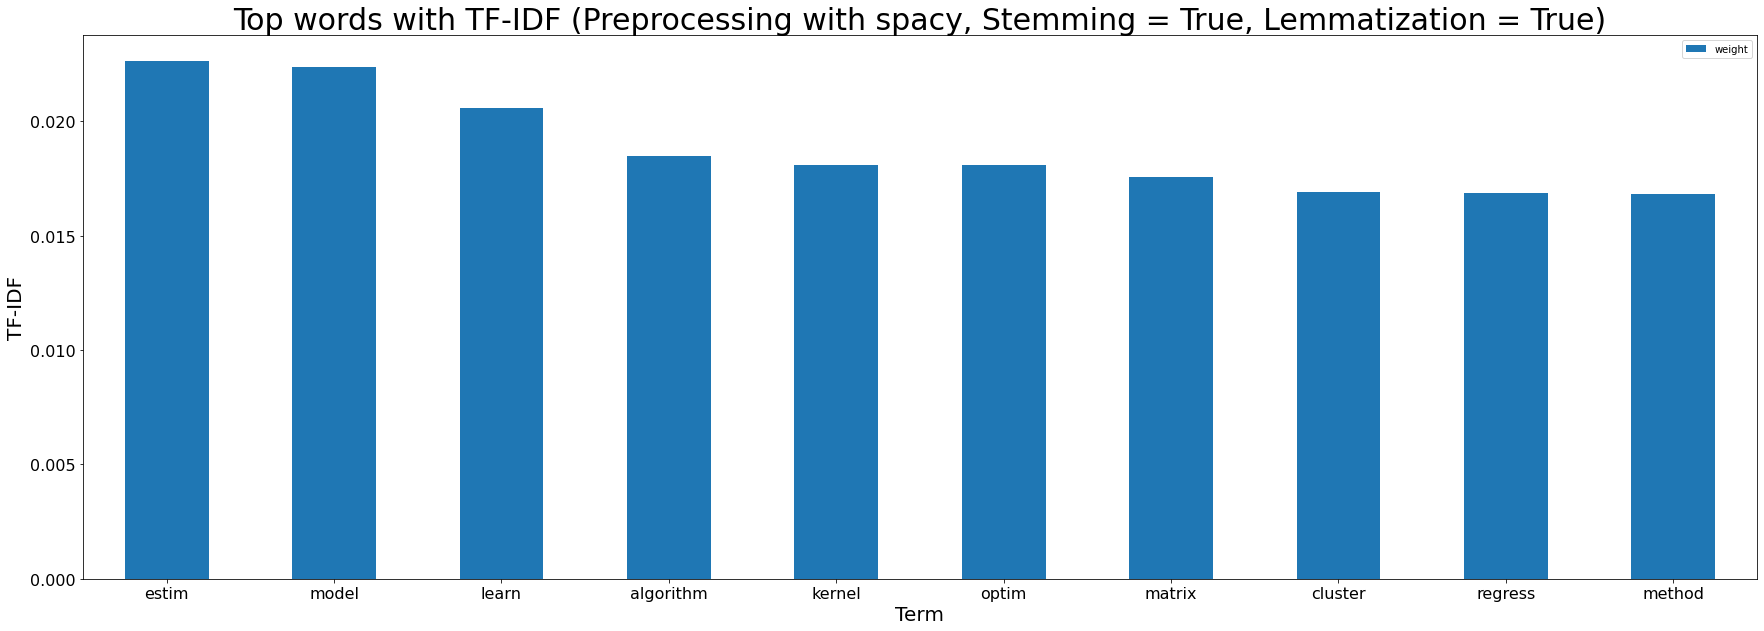

In [575]:
plot_histogram(get_top_words(corpus_tfidf, "weight", "TF-IDF"), "TF-IDF", "weight")


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


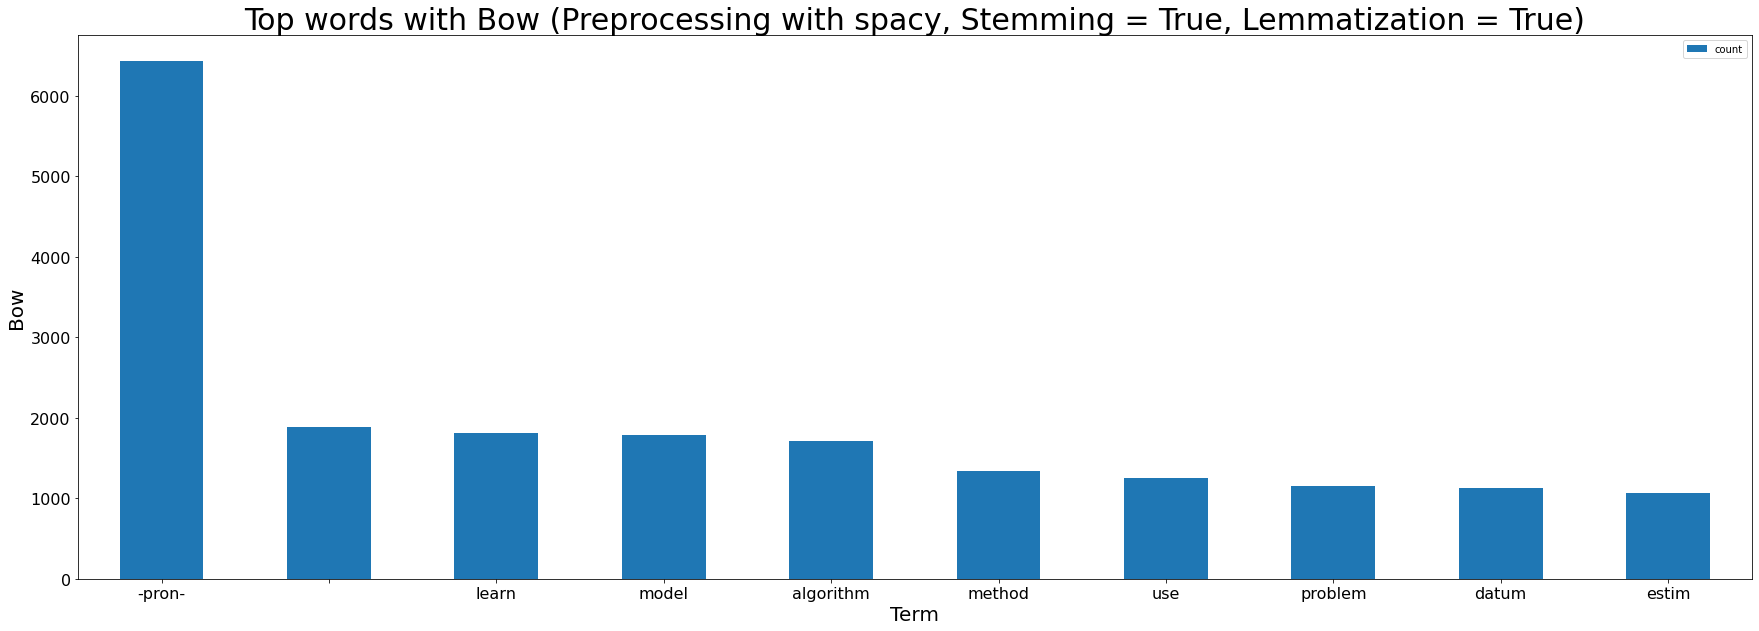

In [576]:
plot_histogram(get_top_words(BoW_corpus, "count", "BoW"), "Bow", "count")

## Topics

In [577]:
lsi_tfidf.print_topics()

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.142*"estim" + 0.128*"model" + 0.114*"kernel" + 0.112*"matrix" + 0.107*"regress" + 0.106*"learn" + 0.104*"optim" + 0.102*"algorithm" + 0.100*"distribut" + 0.100*"method"'),
 (1,
  '0.296*"graph" + 0.244*"cluster" + 0.233*"causal" + -0.185*"convex" + 0.175*"graphic" + -0.169*"kernel" + -0.162*"gradient" + 0.156*"model" + -0.151*"optim" + 0.150*"network"'),
 (2,
  '-0.520*"cluster" + -0.290*"matrix" + 0.264*"polici" + -0.225*"rank" + -0.126*"complet" + -0.114*"tensor" + -0.106*"densiti" + 0.105*"network" + -0.101*"low" + 0.101*"learn"'),
 (3,
  '0.511*"cluster" + 0.279*"polici" + -0.197*"kernel" + -0.181*"estim" + -0.162*"regress" + -0.155*"matrix" + -0.143*"covari" + 0.142*"label" + -0.139*"lasso" + 0.132*"stochast"'),
 (4,
  '0.656*"kernel" + 0.225*"cluster" + 0.139*"densiti" + -0.133*"convex" + -0.127*"polici" + -0.124*"causal" + -0.124*"matrix" + -0.118*"stochast" + -0.104*"gradient" + -0.096*"optim"')]

In [578]:
lsi_bow.print_topics()

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.716*"-pron-" + 0.203*"  " + 0.190*"model" + 0.181*"learn" + 0.181*"algorithm" + 0.139*"method" + 0.129*"use" + 0.122*"problem" + 0.116*"datum" + 0.110*"estim"'),
 (1,
  '-0.724*"model" + 0.299*"algorithm" + -0.191*"estim" + 0.183*"optim" + 0.161*"problem" + -0.149*"datum" + 0.131*"  " + 0.107*"convex" + -0.104*"infer" + -0.100*"latent"'),
 (2,
  '-0.782*"learn" + 0.344*"estim" + 0.132*"-pron-" + -0.124*"model" + 0.107*"matrix" + -0.096*"task" + 0.088*"optim" + 0.088*"  " + -0.080*"machin" + 0.079*"method"'),
 (3,
  '-0.564*"  " + 0.496*"-pron-" + -0.401*"algorithm" + -0.296*"model" + -0.105*"optim" + -0.078*"converg" + -0.077*"gradient" + -0.077*"stochast" + -0.070*"problem" + -0.062*"comput"'),
 (4,
  '0.643*"  " + -0.337*"algorithm" + -0.295*"method" + -0.222*"optim" + 0.187*"-pron-" + -0.150*"problem" + -0.134*"propos" + 0.129*"graph" + -0.125*"estim" + -0.119*"convex"')]

In [579]:
lda_model.print_topics()

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.001*"assort" + 0.000*"pycobra" + 0.000*"season" + 0.000*"qm" + 0.000*"tslearn" + 0.000*"dkrr" + 0.000*"cv" + 0.000*"successor" + 0.000*"mahout" + 0.000*"visualis"'),
 (1,
  '0.007*"assort" + 0.004*"optim" + 0.004*"model" + 0.004*"estim" + 0.003*"product" + 0.003*"network" + 0.003*"polici" + 0.003*"featur" + 0.003*"contextu" + 0.003*"chang"'),
 (2,
  '0.001*"assort" + 0.000*"cooper" + 0.000*"season" + 0.000*"exp3" + 0.000*"qm" + 0.000*"tslearn" + 0.000*"dkrr" + 0.000*"coop" + 0.000*"nonstochast" + 0.000*"cv"'),
 (3,
  '0.001*"assort" + 0.000*"season" + 0.000*"qm" + 0.000*"tslearn" + 0.000*"ehr" + 0.000*"dkrr" + 0.000*"cv" + 0.000*"hasmm" + 0.000*"successor" + 0.000*"mahout"'),
 (4,
  '0.001*"assort" + 0.001*"cubic" + 0.001*"svrc" + 0.000*"lite" + 0.000*"ahc" + 0.000*"ontolog" + 0.000*"snk" + 0.000*"season" + 0.000*"footnot" + 0.000*"qm"')]

## Plot

In [580]:
def plot_2d_space(corpus, method, corpus_name, method_name, use_tsne=False):

    if isinstance(method, models.ldamodel.LdaModel):
        documents_2d_1=[x[0][0][1] for x in method[corpus] if x]
        documents_2d_2=[x[0][1][1] for x in list(method[corpus]) if x]
    else:
        documents_2d_1=[x[0][1] for x in method[corpus] if x]
        documents_2d_2=[x[1][1] for x in list(method[corpus]) if x]


    fig, ax = plt.subplots(figsize=(10,10))

  # Get topic weights
    topic_weights = []
    for i, row_list in enumerate(method[corpus]):
        if row_list:
            if isinstance(method, models.ldamodel.LdaModel):
                topic_weights.append([w for i, w in row_list[0]])
            else:
                topic_weights.append([w for i, w in row_list])

    # Array of topic weights    
    arr = pd.DataFrame(topic_weights).fillna(0).values

    # Dominant topic number in each doc
    topic_num = np.argmax(arr, axis=1)

    if use_tsne:
        tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99)
        tsne = tsne_model.fit_transform(arr)
        documents_2d_1 = tsne[:,0]
        documents_2d_2 = tsne[:,1]
    ax.set_title(f"{corpus_name} in 2D-Space with {method_name} {preprocessing_str}")
    ax.scatter(documents_2d_1, documents_2d_2, c=topic_num, s=80 ,alpha=0.8)
    plt.savefig(Path(f'imgs/{method_name}_{corpus_name}_preprocessing_{lib}_stemming_{stemming}_lemmatization_{lemmatization}_num_topics_{num_topics}.png'))

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


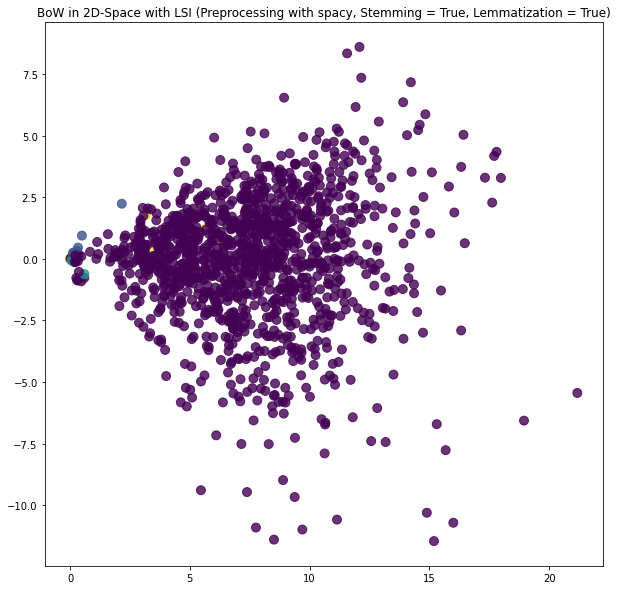

In [581]:
plot_2d_space(BoW_corpus, lsi_bow, "BoW", "LSI")

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


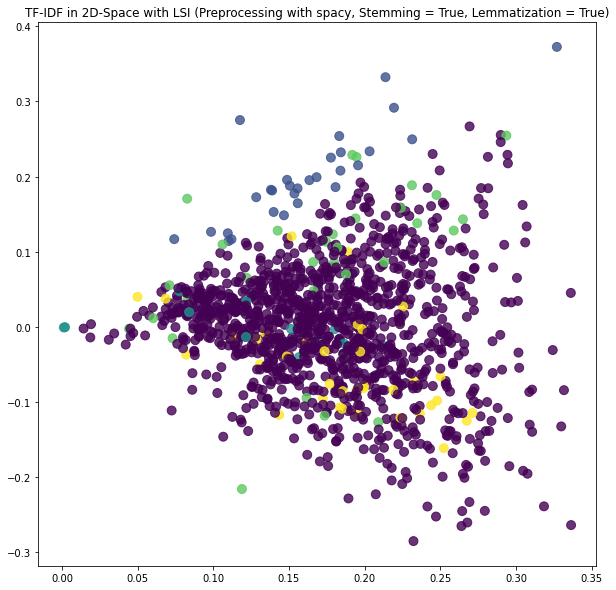

In [582]:
plot_2d_space(corpus_tfidf, lsi_tfidf, "TF-IDF", "LSI")

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


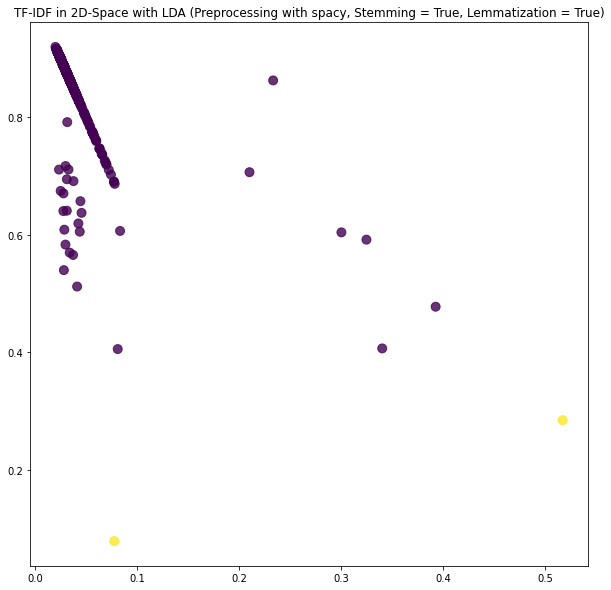

In [583]:
plot_2d_space(corpus_tfidf, lda_model, "TF-IDF", "LDA")

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1261 samples in 0.002s...
[t-SNE] Computed neighbors for 1261 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1261
[t-SNE] Computed conditional probabilities for sample 1261 / 1261
[t-SNE] Mean sigma: 0.000533
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.619759
[t-SNE] KL divergence after 1000 iterations: 0.187961


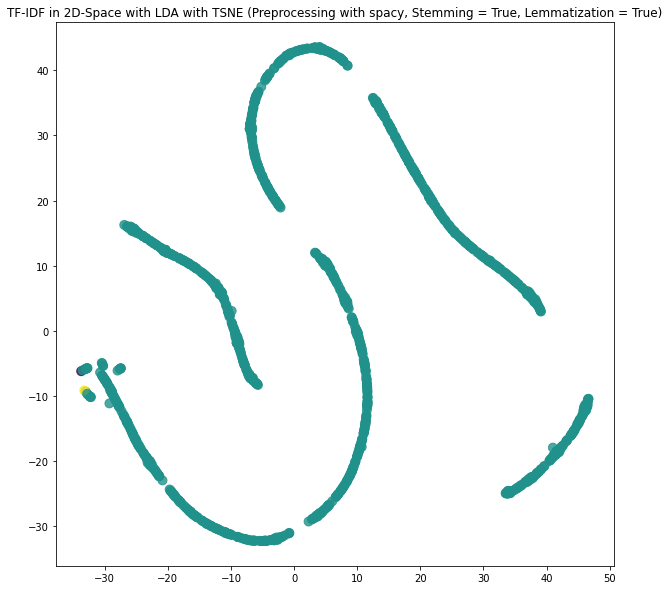

In [584]:
plot_2d_space(corpus_tfidf, lda_model, "TF-IDF", "LDA with TSNE", use_tsne=True)

In [585]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus_tfidf, dictionary=lda_model.id2word, mds='mmds')

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [586]:
vis

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.063260  0.158960       1        1  87.699330
3     -0.015808 -0.039731       2        1   3.108045
2     -0.015860 -0.039716       3        1   3.089586
0     -0.015900 -0.039698       4        1   3.058835
4     -0.015693 -0.039815       5        1   3.044203, topic_info=           Term       Freq      Total Category  logprob  loglift
2939     assort  43.000000  43.000000  Default  30.0000  30.0000
5493     season   7.000000   7.000000  Default  29.0000  29.0000
5456         qm   3.000000   3.000000  Default  28.0000  28.0000
5475         cv   4.000000   4.000000  Default  27.0000  27.0000
5462  successor   3.000000   3.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
1106         lq   0.047132   3.221389   Topic5  -8.4814  -0.7327
5408   inattent   0.046636   2.146839   Topic5  -8.4920  -0.3374
5410     youtub   0.046636   2.146839   Topic5  -8.4920  -0.3374
1134      logit   0.047461   6.088244   Topic5  -8.4745  -1.3623
5460        cen   0.047015   3.373569   Topic5  -8.4839  -0.7813

[343 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.985021           
8         1  0.997944  algorithm
86        1  0.964412   approxim
5389      1  1.080024    apricot
2939      1  0.997483     assort
...     ...       ...        ...
235       1  0.990231       time
5292      1  0.742171    tslearn
2312      1  0.884958        var
5397      1  1.163849       wold
5410      1  0.931602     youtub

[74 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1, 5])